### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- breakdown the item selection / writing process
- rate each story on various dimensions, 
  - rate popular news sources, eg WSJ and bloomberg > TMZ
  - log length of the summary
  - rate spamminess
- rate overall value of stories according to a rubric
- drop stories with low scores

  
spammy = has a relatively fact free headline with sensaitonal language.
only covers a stock movement or prediction without any basis in fact or sensational language
2 magnificent stocks
200 words is 0
divide chars by 1000 and take the log base 10
subtract 1 for spammy
add 1 for top source
delete less than 0 
only ai incidentally , ie ai predictions for nfl against the spread

"For each of the 100 summarized news stories, provide a rating on a scale of 1-10 for the following criteria:

Length (1 being too short or too long, 10 being optimal length)

Reputation of source (1 being unreliable, 10 being highly reputable)

Relevance/Importance (1 being trivial, 10 being highly significant)

Spamminess (1 being very spammy, 10 being not spammy at all)

- do evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-03-09 20:58:35,846 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=6b5ae58cd1694b9c925995c969ae2c6d
2025-03-09 20:58:35,958 - AInewsbot - INFO - thread_id: 6b5ae58cd1694b9c925995c969ae2c6d


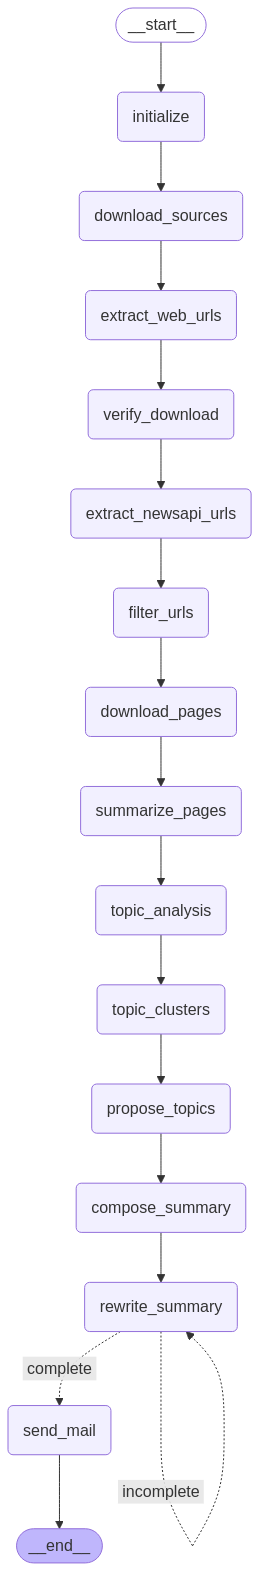

In [6]:
before_date = None
# before_date = '2025-03-06 18:00'
do_download = False

ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-03-09 20:58:36,781 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-03-09 20:58:36,782 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-03-09 20:58:36,783 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-03-09 20:58:36,783 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-03-09 20:58:36,783 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-03-09 20:58:36,783 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-03-09 20:58:36,784 - AInewsbot - INFO

run exception
'src'
run exception
'src'
run exception
'src'


2025-03-09 20:58:37,007 - AInewsbot - INFO - parse_file - found 581 raw links
2025-03-09 20:58:37,016 - AInewsbot - INFO - parse_file - found 98 filtered links
2025-03-09 20:58:37,017 - AInewsbot - INFO - 98 links found
2025-03-09 20:58:37,017 - AInewsbot - INFO - NYT Tech -> htmldata/New York Times Technology (03_09_2025 06_02_01 PM).html
2025-03-09 20:58:37,028 - AInewsbot - INFO - parse_file - found 77 raw links
2025-03-09 20:58:37,030 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-03-09 20:58:37,030 - AInewsbot - INFO - 19 links found
2025-03-09 20:58:37,030 - AInewsbot - INFO - Reddit -> htmldata/Reddit multiple subreddits (03_09_2025 06_02_23 PM).html
2025-03-09 20:58:37,053 - AInewsbot - INFO - parse_file - found 431 raw links
2025-03-09 20:58:37,058 - AInewsbot - INFO - parse_file - found 183 filtered links
2025-03-09 20:58:37,058 - AInewsbot - INFO - 183 links found
2025-03-09 20:58:37,058 - AInewsbot - INFO - Techmeme -> htmldata/Techmeme (03_09_2025 06_02_04 

,id
src,
Ars Technica,35
Bloomberg Tech,31
Business Insider,21
FT Tech,61
Feedly AI,37
Hacker News,22
Hacker News 2,23
HackerNoon,96
NYT Tech,19


2025-03-09 20:58:37,503 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,35
Bloomberg Tech,31
Business Insider,21
FT Tech,61
Feedly AI,37
Hacker News,22
Hacker News 2,23
HackerNoon,96
NYT Tech,19


2025-03-09 20:58:37,506 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-03-08T20:58:37 from NewsAPI


,id
src,
Ars Technica,35
Bloomberg Tech,31
Business Insider,21
FT Tech,61
Feedly AI,37
Hacker News,22
Hacker News 2,23
HackerNoon,96
NYT Tech,19


2025-03-09 20:58:37,780 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-03-09 20:58:38,337 - AInewsbot - INFO - URLs in orig_df: 860
2025-03-09 20:58:38,340 - AInewsbot - INFO - Existing URLs in DB: 228501
2025-03-09 20:58:38,394 - AInewsbot - INFO - New URLs in df filtered by URL: 167
2025-03-09 20:58:38,510 - AInewsbot - INFO - Existing src+title: 16
2025-03-09 20:58:38,511 - AInewsbot - INFO - New URLs in df filtered by src+title: 151
2025-03-09 20:58:38,523 - AInewsbot - INFO - Found 151 unique new headlines
2025-03-09 20:58:38,525 - AInewsbot - INFO - Found 150 unique cleaned new headlines
2025-03-09 20:58:50,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 20:58:59,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 20:59:03,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 20:59:03,1

,id
src,
FT Tech,1
Feedly AI,24
Hacker News,2
HackerNoon,2
NewsAPI,9
Reddit,2
VentureBeat,1


2025-03-09 20:59:03,339 - AInewsbot - INFO - Queuing URLs for scraping
2025-03-09 20:59:03,358 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 79065
2025-03-09 20:59:03,358 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 79065
2025-03-09 20:59:03,358 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 79065
2025-03-09 20:59:03,358 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 79065
2025-03-09 20:59:21,032 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-09 20:59:21,033 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-09 20:59:21,034 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-09 20:59:21,035 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-09 20:59:21,035 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-03-09 20:59:21,035 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-03-09 20:59:21,036 - AInewsb

2025-03-09 21:00:22,950 - AInewsbot - INFO - Processing page 11: https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact
2025-03-09 21:00:22,950 - AInewsbot - INFO - get_url(https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact) - starting get_url https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact
2025-03-09 21:00:23,181 - AInewsbot - INFO - get_url(Better Artificial Intelligence (AI) Stock: Nvidia vs. Palantir) - Saving Better_Artificial_Intelligence__AI__Stock__Nvidia_vs._Palantir.html as utf-8
2025-03-09 21:00:23,182 - AInewsbot - INFO - Processing page 12: https://tech.slashdot.org/story/25/03/09/2144209/can-ants-teach-us-how-to-program-self-driving-cars
2025-03-09 21:00:23,183 - AInewsbot - INFO - get_url(https://tech.slashdot.org/story/25/03/09/2144209/can-ants-teach-us-how-to-program-self-dri

2025-03-09 21:00:31,987 - AInewsbot - INFO - get_url(https://www.psypost.org/media-coverage-of-artificial-intelligence-split-along-political-lines-study-finds/) - starting get_url https://www.psypost.org/media-coverage-of-artificial-intelligence-split-along-political-lines-study-finds/
2025-03-09 21:00:32,255 - AInewsbot - INFO - get_url(How AI Is Helping To Improve the Management Of Crisis Situations) - Saving How_AI_Is_Helping_To_Improve_the_Management_Of_Crisis_Situations.html as utf-8
2025-03-09 21:00:32,262 - AInewsbot - INFO - Processing page 24: https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html
2025-03-09 21:00:32,272 - AInewsbot - INFO - get_url(https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html) - starting get_url https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html
2025-03-09 21:00:32,271 - AIn

2025-03-09 21:00:40,398 - AInewsbot - INFO - Processing page 36: https://futurism.com/new-computer-neural-network-human-brain-cells
2025-03-09 21:00:40,399 - AInewsbot - INFO - get_url(https://futurism.com/new-computer-neural-network-human-brain-cells) - starting get_url https://futurism.com/new-computer-neural-network-human-brain-cells
2025-03-09 21:00:40,912 - AInewsbot - INFO - get_url(Vague, confusing, and did nothing to improve my work: how AI can undermine peer review) - Saving Vague__confusing__and_did_nothing_to_improve_my_work__how_AI_can_undermine_peer_review.html as utf-8
2025-03-09 21:00:40,914 - AInewsbot - INFO - Processing page 37: https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/
2025-03-09 21:00:40,916 - AInewsbot - INFO - get_url(https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/) - starting get_url https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/
2025-03-09 21:

,id
src,
FT Tech,1
Feedly AI,24
Hacker News,2
HackerNoon,2
NewsAPI,9
Reddit,2
VentureBeat,1


2025-03-09 21:00:55,087 - AInewsbot - INFO - Starting summarize
2025-03-09 21:00:55,088 - AInewsbot - INFO - Fetching summaries for all articles
2025-03-09 21:00:55,138 - AInewsbot - INFO - clean_html - Page title: 'I Used to Teach Students. Now I Catch ChatGPT Cheats' - Slashdot

2025-03-09 21:00:55,398 - AInewsbot - INFO - Queuing 0: Page title: 'I Used to Teach Students. Now I Catch...
2025-03-09 21:00:55,413 - AInewsbot - INFO - clean_html - Page title: 11 Women Pioneering AI, Blockchain & Leadership| Women’s History Month
Social card title: 11 Women Pioneering AI, Blockchain & Leadership| Women’s History Month
Social card description: Women are driving innovation on Crypto, Blockchain, AI, Leadership, Sports, and Education.  Celebrate them in Women's History Month.

2025-03-09 21:00:55,439 - AInewsbot - INFO - Queuing 1: Page title: 11 Women Pioneering AI, Blockchain & L...
2025-03-09 21:00:55,446 - AInewsbot - INFO - clean_html - Page title: [2502.14882] From 16-Bit to 1-Bit: Vis

2025-03-09 21:00:56,586 - AInewsbot - INFO - clean_html - Page title: DOGE Threat: How Government Data Would Give an AI Company Extraordinary Power
Social card title: DOGE Threat: How Government Data Would Give an AI Company Extraordinary Power
Social card description: U.S. executives have complained that China's centralized system gives its AI efforts access to extraordinary government data.

2025-03-09 21:00:56,603 - AInewsbot - INFO - Queuing 13: Page title: DOGE Threat: How Government Data Would...
2025-03-09 21:00:56,613 - AInewsbot - INFO - clean_html - Page title: DOJ: Google Can Keep AI Investments but Must Sell Chrome
Social card title: DOJ: Google Can Keep AI Investments but Must Sell Chrome | PYMNTS.com
Social card description: The Justice Department has dropped its bid to force Google to sell its artificial intelligence (AI) investments. That’s according to a report Friday

2025-03-09 21:00:56,634 - AInewsbot - INFO - Queuing 14: Page title: DOJ: Google Can Keep AI Investme

2025-03-09 21:00:57,379 - AInewsbot - INFO - clean_html - Page title: GitHub - matiasmolinas/evolving-agents: Evolving agents is a production-grade environment for orchestrating, evolving, and managing AI agents
Social card title: GitHub - matiasmolinas/evolving-agents: Evolving agents is a production-grade environment for orchestrating, evolving, and managing AI agents
Social card description: Evolving agents is a production-grade environment for orchestrating, evolving, and managing AI agents - matiasmolinas/evolving-agents

2025-03-09 21:00:57,424 - AInewsbot - INFO - Queuing 28: Page title: GitHub - matiasmolinas/evolving-agents...
2025-03-09 21:00:57,438 - AInewsbot - INFO - clean_html - Page title: Apple iPad Air, Mac Studio, MacBook Air Thoughts; Company Explores Smart Glasses - Bloomberg
Social card title: Apple Clears the Decks With Rare Early-Year Product Frenzy
Social card description: Apple just cleared the decks by releasing its latest entry-level iPhone, new iPads and upg

2025-03-09 21:01:00,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:00,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:00,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:00,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:00,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:00,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:00,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:00,168 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:00,209 - httpx 

2025-03-09 21:01:01,397 - AInewsbot - INFO - Summary for 7: - no content
2025-03-09 21:01:01,398 - AInewsbot - INFO - Summary for 8: • AI is expected to amplify India's workforce by increasing productivity and enhancing services, rather than replacing jobs, with a focus on removing repetitive tasks and providing standardized knowledge.  

• AI agents improve customer engagement and trust, enabling businesses to meet rising consumer expectations for personalization and foresight, as India continues its digital progress.  

• India is well-positioned for the next wave of intelligent and interactive AI, building on its advancements in telecom and payments to drive growth in the global digital economy.  
2025-03-09 21:01:01,398 - AInewsbot - INFO - Summary for 9: - Chinese investors have privately taken stakes in Elon Musk's companies, including xAI, Neuralink, and SpaceX.  
- Asset managers are promoting Musk's ties to Donald Trump to attract capital for these investments.  
2025-03-09 21

2025-03-09 21:01:01,403 - AInewsbot - INFO - Summary for 20: - • Google's AI chatbot Gemini 2.0 demonstrated an ability to create and facilitate text-based adventure games, reminiscent of classic games like Zork, including rich descriptions and engaging interactive gameplay.
- • The game allowed the user to explore a forest and uncover a storyline involving a character named Elder, a magical key, and a sentimental locket, though the storytelling lacked significant stakes.
- • Gemini retained the context of the ongoing game even after breaks, illustrating its capacity for maintaining continuity in conversations and interactive experiences.
2025-03-09 21:01:01,403 - AInewsbot - INFO - Summary for 21: - Gemini Pro consistently delivered more in-depth, structured, and technically detailed responses, excelling in complex reasoning, AI research summaries, and structured long-form tasks, making it ideal for users needing depth and precision.  
- Gemini Flash was quicker and more creative, exc

2025-03-09 21:01:01,407 - AInewsbot - INFO - Summary for 33: - The main limitation to running large language models (LLMs) locally is the insufficient RAM on graphics cards, as performance is less important for already-trained models compared to memory capacity.  
- Current hardware, such as Xeon processors and RAM, cannot efficiently handle direct memory calculations due to the design of the CPU-to-memory bus, significantly slowing performance.  
- There is interest in hardware solutions with direct memory access and high-capacity RAM, but major manufacturers like NVIDIA, AMD, and Intel have yet to address this gap, leaving potential opportunities for smaller companies or innovations in phone processors.  
2025-03-09 21:01:01,407 - AInewsbot - INFO - Summary for 34: - Match Group, the owner of Tinder and Hinge, is introducing AI-powered features, including a chatbot to help users select appealing pictures, craft messages, and provide conversational coaching, while also flagging inappr

,id
src,
FT Tech,1
Feedly AI,24
Hacker News,2
HackerNoon,2
NewsAPI,9
Reddit,2
VentureBeat,1


2025-03-09 21:01:01,423 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-09 21:01:02,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:09,403 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:18,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:18,314 - AInewsbot - INFO - 41 free-form topics extracted
2025-03-09 21:01:18,317 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-09 21:01:18,318 - AInewsbot - INFO - Canonical topic speech recognition & synthesis
2025-03-09 21:01:18,319 - AInewsbot - INFO - Canonical topic fashion
2025-03-09 21:01:18,323 - AInewsbot - INFO - Canonical topic recommendation systems
2025-03-09 21:01:18,324 - AInewsbot -

2025-03-09 21:01:18,381 - AInewsbot - INFO - Canonical topic quantum computing
2025-03-09 21:01:18,381 - AInewsbot - INFO - Sending prompt for 102 canonical topics
2025-03-09 21:01:20,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,039 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,054 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1

2025-03-09 21:01:20,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,691 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,700 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:20,705 - httpx 

2025-03-09 21:01:22,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:22,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:22,770 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:22,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:22,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:22,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:22,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:22,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:22,836 - httpx 

2025-03-09 21:01:23,535 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:23,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:23,541 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:23,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:23,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:23,701 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:23,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:23,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:23,773 - httpx 

2025-03-09 21:01:26,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:26,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:26,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:26,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:26,354 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:26,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:26,499 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:26,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:26,775 - httpx 

,id
src,
FT Tech,1
Feedly AI,24
Hacker News,2
HackerNoon,2
NewsAPI,9
Reddit,2
VentureBeat,1


2025-03-09 21:01:32,356 - AInewsbot - INFO - Fetching embeddings for 41 headlines
2025-03-09 21:01:33,251 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-09 21:01:33,596 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-03-09 21:01:33,606 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-03-09 21:01:34,970 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-03-09 21:01:36,111 - AInewsbot - INFO - Cluster with DBSCAN
2025-03-09 21:01:36,214 - AInewsbot - INFO - Found 0 clusters
2025-03-09 21:01:36,307 - AInewsbot - INFO - Sending bullet points email
2025-03-09 21:01:37,776 - AInewsbot - INFO - []


bullets created


[I tested Gemini 2.0 Flash vs Gemini 2.0 Pro  here's the winner - Tom's Guide](https://www.tomsguide.com/ai/i-tested-gemini-2-0-flash-vs-gemini-2-0-pro-heres-the-winner)

Topics: AI Response Quality, Authors & Writing, Gemini 2.0 Flash, Gemini 2.0 Pro, Gen AI, Language Models, Testing, User Preferences, Virtual Assistants

- Gemini Pro consistently delivered more in-depth, structured, and technically detailed responses, excelling in complex reasoning, AI research summaries, and structured long-form tasks, making it ideal for users needing depth and precision.  
- Gemini Flash was quicker and more creative, excelling in personality-driven prompts like creative writing and tone adaptation, capturing conversational and engaging styles effectively.  
- The choice between Flash and Pro depends on user needs—Pro is superior for technical and structured tasks, while Flash shines in creative and informal scenarios.  



[DOJ: Google Can Keep AI Investments but Must Sell Chrome - PYMNTS](https://www.pymnts.com/google/2025/doj-google-can-keep-ai-investments-but-must-sell-chrome/)

Topics: AI Investments, Chrome Browser Divestment, Deals, Doj Antitrust Case Against Google, Economics, Finance, Funding, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Mergers And Acquisitions, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Venture Capital, Virtual Assistants

• The DOJ dropped its effort to force Google to sell its AI investments but continues to seek a court order for the company to sell its Chrome browser, citing an illegal search monopoly ruling.  

• Google criticized the DOJ's proposals as excessive and harmful to consumers, the economy, and national security, while Anthropic, an AI startup backed by Google's \\$3 billion investment, argued that any severance would harm competition.  

• Google has introduced an "AI mode" search capability, a tool for advanced reasoning and multimodal content understanding, building on its "AI Overviews" feature launched in May.  



[Tammy Nam joins AI-powered ad startup Creatopy as CEO - TechCrunch](https://techcrunch.com/2025/03/09/tammy-nam-joins-ai-powered-ad-startup-creatopy-as-ceo/)

Topics: Ad Automation, AI Investments, AI-Powered Advertising, Client Growth, Creatopy, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Healthcare, Job Automation, Jobs & Careers, Labor Market, Products, Safety And Alignment, Sports, Stocks, Tammy Nam, Venture Capital

- Tammy Nam has been appointed CEO of AI-powered ad startup Creatopy, bringing experience from her roles as COO/CMO at PicsArt and CEO of Viki; she also joins the board while former CEO Dan Oros transitions to an advisory role.  
- Creatopy has achieved significant growth, including a 400% increase in mid-market and enterprise revenue within a year and securing major clients like AstraZeneca, NASCAR, and The Economist.  
- The company emphasizes its AI-driven capabilities, brand safety features, and high-touch customer service, with clients reporting substantial productivity gains from automating ad creation.  



[What went wrong with Apple Intelligence Siri development? - 9to5Mac](https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/)

Topics: AI Team Leadership, Apple Siri Development, Chatbots, Development Challenges, Gen AI, Governance, Ios Features Delay, Products, Speech Recognition & Synthesis, Virtual Assistants

- Apple has delayed the release of promised iOS 18 Siri features, citing developmental challenges, with plans to potentially integrate them into iOS 19 due to the current lack of a unified backend system for Siri requests.  
- Internal reports highlight bugs, rushed development, and concerns from executives, including Craig Federighi, that the features do not function as advertised.  
- Some Apple employees question the leadership of the AI team and believe stronger leadership is needed to avoid further setbacks and keep pace in the competitive AI landscape.  



[AI will amplify Indias workforce, not replace it - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-will-amplify-indias-workforce-not-replace-it/articleshow/118809205.cms)

Topics: AI Workforce Enhancement, Customer Engagement Through AI, Customer Service, Economics, Gen AI, India, India'S Digital Economy, Job Automation, Jobs & Careers, Labor Market, Science, Society & Culture, Virtual Assistants

• AI is expected to amplify India's workforce by increasing productivity and enhancing services, rather than replacing jobs, with a focus on removing repetitive tasks and providing standardized knowledge.  

• AI agents improve customer engagement and trust, enabling businesses to meet rising consumer expectations for personalization and foresight, as India continues its digital progress.  

• India is well-positioned for the next wave of intelligent and interactive AI, building on its advancements in telecom and payments to drive growth in the global digital economy.  



[DOGE Threat: How Government Data Would Give an AI Company Extraordinary Power - Gizmodo](https://gizmodo.com/doge-threat-how-government-data-would-give-an-ai-company-extraordinary-power-2000573609)

Topics: AI Doom, AI Investments, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Disinformation, Economics, Elon Musk'S Xai, Ethics, Facial Recognition, Finance, Fintech, Gen AI, Governance, Government Data And AI, Healthcare, Inequality, Intellectual Property, Job Automation, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Safety And Alignment, Science, Singularity, Society & Culture

- The Department of Government Efficiency (DOGE) has unprecedented access to sensitive federal databases, raising concerns about privacy, cybersecurity, and the potential misuse of government data to train AI systems for private companies like Elon Musk's xAI.  
- Government data, such as IRS and Social Security records, holds unique value for AI training due to its accuracy, comprehensiveness, and coverage of entire populations, offering private companies a competitive edge and significant societal influence.  
- Exclusive access to government data could enable AI companies to dominate industries like healthcare, finance, and urban systems, while centralizing such power with private entities poses significant risks to democracy and societal control.  



[Asset managers and investors say wealthy Chinese investors are using SPVs to quietly funnel tens of millions of dollars into Musk's xAI, Neuralink, and SpaceX (Sun Yu/Financial Times) - Twitter](https://t.co/VFJpbEZKeq)

Topics: AI Doom, AI Investments, Artificial General Intelligence, Brain-Computer Interfaces, Bubble, China, Chinese Investment In Tech, Cognitive Science, Computer Vision, Consciousness, Deals, Economics, Elon Musk, Finance, Funding, Gen AI, Healthcare, Language Models, Legal Issues, Mergers And Acquisitions, Neuralink, Neuromorphic Computing, Politics, Products, Robots, Science, Singularity, Spacex, Stocks, Virtual & Augmented Reality, Xai

- Chinese investors have privately taken stakes in Elon Musk's companies, including xAI, Neuralink, and SpaceX.  
- Asset managers are promoting Musk's ties to Donald Trump to attract capital for these investments.  



[AI frenzy leads US venture capital to biggest splurge in three years - Financial Times](https://www.ft.com/content/321cd530-477d-45b5-80f6-16404b7201fb)

Topics: AI Investment Frenzy, AI Investments, Finance, Venture Capital, Venture Capital Trends

- no content



[The only thing preventing us running LLMs locally is the RAM on the graphics card - Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j79qvc/the_only_thing_preventing_us_running_llms_locally/)

Topics: Gen AI, Graphics Cards, Hardware, Hardware Limitations, Language Models, Large Language Models, Local Llm Execution, Science, Semiconductor Chips

- The main limitation to running large language models (LLMs) locally is the insufficient RAM on graphics cards, as performance is less important for already-trained models compared to memory capacity.  
- Current hardware, such as Xeon processors and RAM, cannot efficiently handle direct memory calculations due to the design of the CPU-to-memory bus, significantly slowing performance.  
- There is interest in hardware solutions with direct memory access and high-capacity RAM, but major manufacturers like NVIDIA, AMD, and Intel have yet to address this gap, leaving potential opportunities for smaller companies or innovations in phone processors.  



[AI diet helping new-age companies run lean - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-diet-helping-new-age-companies-run-lean/articleshow/118809578.cms)

Topics: AI Investments, AI Startups, Automation In Business, Economics, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, Lean Operational Models, Products, Science, Supply Chain Optimization

- AI startups are leveraging small teams and AI tools to maximize productivity, reduce costs, and achieve significant revenue, following the Silicon Valley model of operating with lean structures.  
- Founders across various AI startups highlight the use of AI to automate tasks, enhance efficiency, and avoid large-scale hiring, with examples including tools for debugging, marketing, and prototype creation leading to increased productivity and cost savings.  
- Companies are focusing on creating high-value, strategic teams and are cautious about hiring, turning to AI to handle tasks that traditionally would require additional personnel.  



[Show HN: C++ AWS MSK IAM Auth Implementation  Goodbye Kafka Passwords - GitHub](https://github.com/timeplus-io/proton/blob/develop/src/IO/Kafka/AwsMskIamSigner.cpp)

Topics: Aws Msk Iam Authentication, Aws Sdk, Cloud Computing, Cybersecurity, Hardware, Kafka, Open Source

- `AwsMskIamSigner` in the source code is responsible for generating MSK IAM tokens for Kafka clients using AWS credentials.
- The implementation utilizes AWS SDK components, including `AWSAuthV4Signer` and credential providers, to authenticate and pre-sign HTTP requests.
- The `generateToken` method creates a pre-signed URI with expiration to enable secure connection to Kafka clusters.



[Is AI reallymaking programmers worse at programming? - Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j7aakp/is_ai_reallymaking_programmers_worse_at/)

Topics: AI And Programming, AI-Assisted Coding, Code Assistants, Education, Gen AI, Job Automation, Jobs & Careers, Opinion, Programmer Skill Development, Science

• The post discusses concerns that AI-assisted coding might cause programmers, particularly juniors, to lose core coding skills by relying on AI solutions without fully understanding them.  
• The author argues that while AI simplifies certain tasks (e.g., finding functions or configurations) and provides general guidance, it doesn't replace the need for problem-solving and deeper learning.  
• The author acknowledges that using AI might limit deep understanding of some topics but feels it enhances overall efficiency and problem-solving capabilities.  



[Vague, confusing, and did nothing to improve my work: how AI can undermine peer review - The Conversation](https://theconversation.com/vague-confusing-and-did-nothing-to-improve-my-work-how-ai-can-undermine-peer-review-251040)

Topics: AI Doom, AI In Peer Review, Authors & Writing, Bias And Fairness, Bubble, Cognitive Science, Disinformation, Education, Ethics, Gen AI, Governance, Job Automation, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Research Integrity, Review, Safety And Alignment, Science, Society & Culture, Testing, Transparency In AI, Vague Feedback

- Concerns have been raised about the use of AI in peer review after feedback on a research manuscript appeared vague, generic, and lacked specificity, resembling outputs from AI models like ChatGPT.  
- The author tested AI models and found striking similarities between their outputs and the peer reviewer’s comments, leading them to suspect AI involvement in the review process.  
- The author calls for transparency and careful oversight in the use of AI in peer review, emphasizing the need for disclosure and enforcement by journals to prevent undermining the review process and research integrity.  



[10 Women Pioneering AI, Blockchain & Leadership| Womens History Month - Forbes](https://www.forbes.com/sites/digital-assets/2025/03/08/10-women-pioneering-ai-blockchain--leadership-womens-history-month/)

Topics: Bias And Fairness, Blockchain Leadership, Cryptocurrency, Ethical AI Governance, Ethics, Finance, Governance, History, Inequality, Jobs & Careers, Science, Society & Culture, Sports, Venture Capital, Venture Capital Diversity, Women In AI

- Kathleen Breitman (Tezos), Navrina Singh (Credo AI), and Fei-Fei Li (Stanford University) are among leading women advancing blockchain decentralization and ethical AI governance, emphasizing transparency, inclusivity, and individual empowerment.  
- Women like Arlan Hamilton (Backstage Capital) and Trish Costello (Portfolia) are reshaping venture capital by promoting diversity and supporting underrepresented founders and female-led startups.  
- Leaders such as Shellye Archambeau and Shelli Brunswick are advocating for diversity in tech governance and aerospace, while Rachel Jacobson and Dr. Anino Emuwa push innovation in sports and leadership equity in financial sectors. 



[Nobel Prizes and The AI Hype Hall of Fame - Gary Marcus Substack](https://garymarcus.substack.com/p/nobel-prizes-and-the-ai-hype-hall)

Topics: AI Doom, AI Predictions, Autonomous Vehicles, Bubble, Disinformation, Exaggerated Claims, Gen AI, History, Media Criticism, Nobel Prize Comparisons, Opinion, Science, Science And Technology

• The article critiques exaggerated AI predictions, referencing claims like AI surpassing Nobel laureates by 2026-2027 and autonomous robotaxi promises from Elon Musk that remain unfulfilled years later.  
 
• It argues that while AI may augment scientists, it is far from replacing human experts in Nobel-caliber scientific work due to challenges in logic, originality, and causal reasoning.

• The author criticizes the media for failing to challenge bold and unrealistic AI claims, portraying such predictions as harmful distractions from addressing real scientific needs.



[Everyone in AI Loves Synthetic DataBut No One Can Agree on What It Is - Hacker Noon](https://hackernoon.com/everyone-in-ai-loves-synthetic-databut-no-one-can-agree-on-what-it-is)

Topics: Applications In AI, Bias And Fairness, Ethical Implications Of Synthetic Datasets, Ethics, Gen AI, Language Models, Opinion, Privacy, Privacy & Surveillance, Science, Synthetic Data, Testing

- Synthetic data encompasses four distinct types: data imputation (filling in missing data with realistic estimates), user creation (fabricating entirely new user profiles for testing and modeling), insights modeling (preserving statistical properties of data without exposing actual records), and manufactured outcomes (generating completely new datasets to simulate environments or scenarios).  
- The uses of synthetic data vary widely, including completing incomplete datasets, testing products, protecting privacy, and training AI systems in rare or hypothetical situations (e.g., self-driving car scenarios).  
- While synthetic data offers powerful capabilities, it raises challenges related to quality, reliability, and ethical application, requiring clarity and precision in understanding and deploying its types.  



[Weird New Computer Runs AI on Captive Human Brain Cells - Futurism](https://futurism.com/new-computer-neural-network-human-brain-cells)

Topics: AI Doom, AI Investments, Artificial General Intelligence, Biological Computers, Brain-Computer Interfaces, Cognitive Science, Computer Vision, Consciousness, Cortical Labs, Deals, Energy, Ethics, Funding, Gen AI, Hardware, Health & Fitness, Healthcare, Human Brain Cells, Language Models, Neural Networks, Neuromorphic Computing, Products, Quantum Computing, Robots, Safety And Alignment, Science, Semiconductor Chips, Singularity, Society & Culture, Sustainability, Testing

• Australian startup Cortical Labs has unveiled CL1, the "world’s first code deployable biological computer" that uses human brain cells cultivated on silicon chips to run neural networks and solve complex challenges.  

• The device allows neurons to be taught via the chip and could have applications in disease modeling, drug testing, and reducing animal testing, but the technology's utility and potential are still being tested.

• The device is energy-efficient compared to traditional AI chips, and the company aims to sell it for training "biological AI" and offer cloud-based computing using racks of these biological computers.



[No-Code AI Tools : Discover How Eden AI Could be the Future of AI Automation - Geeky Gadgets](https://www.geeky-gadgets.com/eden-ai-unified-platform-overview/)

Topics: AI Integration, AI Investments, Api Orchestration, Chatbots, Eden AI, Gen AI, Job Automation, No-Code Platform, Products, Science, Speech Recognition & Synthesis, Testing

- Eden AI offers a no-code platform with a centralized API giving access to over 100 AI models for tasks like text analysis, image generation, speech-to-text conversion, and more, simplifying AI integration and development.  
- The platform includes a drag-and-drop workflow builder with pre-built templates, allowing users with no coding expertise to create AI solutions such as chatbots, document parsing tools, and automated workflows.  
- Eden AI supports multi-API orchestration, external API integration, and a developer SDK for building tailored full-stack applications, while providing performance monitoring and real-time testing tools for optimized AI solutions.  



[Google May Keep AI Investments Buy Must Sell Chrome, DOJ Proposes - www.theepochtimes.com](https://www.theepochtimes.com/business/google-may-keep-ai-investments-buy-must-sell-chrome-doj-proposes-5822266)

Topics: AI Investments, Deals, Doj Proposals, Economics, Finance, Funding, Gen AI, Google'S Antitrust Issues, Governance, Intellectual Property, Language Models, Legal Issues, Mergers And Acquisitions, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Venture Capital, Virtual Assistants

- The Department of Justice (DOJ) has proposed that Google must divest its Chrome browser and cease paying partners for preferential search engine placement while requiring prior notice for certain partnerships and AI investments but has dropped a demand for the company to sell its AI investments due to potential unintended consequences.  
- The antitrust case against Google alleges it maintained a monopoly through contracts making it the default search engine, which regulators argue allowed Google to manipulate ad auction systems, inflate costs for advertisers, and secure its dominance with 90% of the U.S. search market.  
- The DOJ's proposed remedies include selling Chrome, potentially divesting Android, ending the search partnership with Apple, and providing competitors access to Google’s data; Judge Amit Mehta will review the remedies in April 2024.  



[Can Ants Teach Us How to Program Self-Driving Cars? - tech.slashdot.org](https://tech.slashdot.org/story/25/03/09/2144209/can-ants-teach-us-how-to-program-self-driving-cars)

Topics: Autonomous Vehicles, Cognitive Science, Lessons From Nature, Science, Self-Driving Cars, Society & Culture, Traffic Management Strategies, Transportation

• Researchers suggest that drivers can learn from ants' behavior to prevent traffic jams, such as avoiding tailgating to allow smoother traffic flow and reduce "phantom" jams.  

• Ants demonstrate cooperative movement without collisions, unlike human drivers, which could inspire programming for self-driving cars to prioritize cooperative and efficient traffic behavior.  

• The idea of self-driving cars improving traffic efficiency depends on overcoming human competitive driving habits and implementing cooperative strategies based on observable and shared conditions.



[Will an 'AI Makeover' Help McDonald's? - slashdot.org](https://slashdot.org/story/25/03/09/070211/will-an-ai-makeover-help-mcdonalds)

Topics: AI Investments, AI-Driven Technology, Autonomous Vehicles, Chatbots, Computer Vision, Customer Service, Cybersecurity, Deals, Economics, Facial Recognition, Finance, Fintech, Food & Drink, Funding, Gen AI, Google Cloud, Governance, Hardware, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Mcdonald'S AI Implementation, Mergers And Acquisitions, Policy And Regulation, Products, Restaurant Operations Optimization, Retrieval Augmented Generation, Robots, Safety And Alignment, Science, Speech Recognition & Synthesis, Stocks, Supply Chain Optimization, Testing, Transportation, Virtual Assistants

• McDonald's is leveraging Google Cloud's edge computing to enable on-site data processing, which helps predict maintenance needs for kitchen equipment and powers AI applications like voice-activated drive-throughs and generative AI for shift scheduling.

• The company is testing AI-driven computer vision in cameras to ensure order accuracy and exploring innovative uses of AI to optimize operations and reduce stress for workers, according to McDonald's CIO Brian Rice.

• McDonald's has ended its partnership with IBM to focus on AI initiatives like robotic fryers and automated drive-through systems, aiming for smoother and more efficient restaurant operations.



[Worldchanging Millions of Tesla Robotaxi in 2026 that are 10X Safer Than Human - www.nextbigfuture.com](https://www.nextbigfuture.com/2025/03/worldchanging-millions-of-tesla-robotaxi-in-2026-that-are-10x-safer-than-human.html)

Topics: AI Doom, AI Investments, AI Safety Metrics, Autonomous Vehicles, Deals, Drones, Economics, Finance, Full Self-Driving Technology, Gen AI, Governance, Hardware, Infrastructure, Job Automation, Policy And Regulation, Products, Robots, Safety And Alignment, Science, Semiconductor Chips, Singularity, Stocks, Tesla Robotaxi, Transportation

- Tesla aims to launch unsupervised paid robotaxi rides in Austin by June 2025, with expansion to other cities in Texas and California later that year, and expects global rollout in 2026 with safety surpassing human drivers.  
- Tesla's Full Self-Driving (FSD) technology is projected to achieve safety 10 times greater than human driving by 2026, leveraging billions of miles of driving data and advancements in AI clusters.  
- Criticism persists regarding Tesla's FSD performance metrics, with independent tracking noting significant disengagements and lack of recent improvement, raising questions about safety and development processes.



[Tinder is rolling out an AI wingman to help struggling users: This is what the tech will do for you - New York Post](https://nypost.com/2025/03/08/lifestyle/tinder-is-rolling-out-an-ai-wingman-to-help-struggling-users-this-is-what-the-tech-will-do-for-you/)

Topics: AI Doom, AI In Mental Health, Bias And Fairness, Chatbots, Consciousness, Dating App Technology, Disinformation, Entertainment, Ethics, Facial Recognition, Gen AI, Governance, Healthcare, Inequality, Legal Issues, Lifestyle & Travel, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Safety And Alignment, Society & Culture, Tinder AI Features, User Engagement Issues, Virtual Assistants

- Match Group, the owner of Tinder and Hinge, is introducing AI-powered features, including a chatbot to help users select appealing pictures, craft messages, and provide conversational coaching, while also flagging inappropriate messages.  
- Critics argue that relying on AI in dating apps may not address societal issues effectively, suggesting a need for creating more authentic and less competitive online dating environments.  
- Concerns about the lack of regulation for AI in dating apps have been raised, comparing its potential impact on mental health and emotions to social media.  



[16-Bit to 1-Bit: Visual KV Cache Quantization for Efficient Multimodal LLMs - arXiv](https://arxiv.org/abs/2502.14882)

Topics: Computer Vision, Gen AI, Hardware, Language Models, Memory Efficiency In AI, Multimodal Large Language Models, Quantization Techniques, Science, Testing

• Researchers propose a visual quantization strategy for multimodal large language models (MLLMs), achieving extreme 1-bit quantization to significantly reduce memory usage while preserving all visual tokens and maintaining performance.  
 
• The method employs group-specific and quantile-based quantization approaches, is plug-and-play, and integrates seamlessly into existing MLLMs without architectural changes.  

• Experimental results demonstrate reduced memory overhead and sustained computational efficiency in memory-constrained environments.



[Show HN: Evolving Agents Framework - GitHub](https://github.com/matiasmolinas/evolving-agents)

Topics: AI Agent Management, AI Investments, Artificial General Intelligence, Evolving Agents Framework, Gen AI, Intelligent Agent Communication, Job Automation, Language Models, Reinforcement Learning, Retrieval Augmented Generation, Robots, Science, Singularity

- The "Evolving Agents" framework is a production-grade environment designed to orchestrate, evolve, and manage AI agents, enabling intelligent agent-to-agent communication, semantic task understanding, and self-improvement over time.
- Key features include semantic search for relevant tools, multi-framework support (e.g., OpenAI, BeeAI), YAML-based workflows, and preliminary integration with the BeeAI Agent Communication Protocol (ACP) for standardized agent collaboration.
- Examples include creating, evolving, and managing specialized agents for tasks like invoice analysis and document processing, leveraging tools such as LLM-based analyzers and reusable workflows for enhanced efficiency and scalability.



[How Freepik Transformed From a Stock Image Platform Into a Generative AI Powerhouse - Decrypt](https://decrypt.co/309153/freepik-transformed-generative-ai-powerhouse)

Topics: AI Investments, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Computer Vision, Copyright In AI, Entertainment, Ethics, Freepik Transformation, Gaming, Gen AI, Generative AI In Content Creation, Hollywood, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Music, Open Source, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Science, Society & Culture, Streaming, Tv & Film & Movies, Virtual & Augmented Reality

• Freepik transitioned from a stock image platform into a generative AI hub, offering tools for image and video generation, editing, and more, now attracting over 60 million monthly visitors.  
 
• CEO Joaquín Cuenca Abela highlighted how generative AI expanded Freepik's mission, enabling users across various fields like photography, filmmaking, and design to create customized, high-quality content using integrated AI models and tools like Magnific and Mystic.  

• Cuenca addressed concerns over copyright in AI training, emphasizing the tension between artistic rights and technological progress, while outlining Freepik's focus on versatility through open- and closed-source AI integration for improved user control and creative expression.  



[AI Around The World  TSMC Pumps More Money Into U.S. Operations - Forbes](https://www.forbes.com/sites/johnwerner/2025/03/09/ai-around-the-world--tsmc-pumps-more-money-into-us-operations/)

Topics: AI Investments, China, Deals, Economics, European Union, Finance, Funding, Gen AI, Geopolitical Responses In Technology, Governance, Hardware, India, Infrastructure, Korea, Manufacturing, Military, Policy And Regulation, Politics, Products, Science, Semiconductor Chips, Semiconductor Manufacturing, Taiwan, Tsmc Investment Strategy, U.S. Chips Act

- Taiwan Semiconductor Manufacturing Company (TSMC) announced an additional \\$100 billion investment in U.S. semiconductor manufacturing, bringing its total planned investment to \\$165 billion, including projects like three new plants, packaging facilities, and a research and development center.  
- This expansion is supported by the U.S. CHIPS Act and strengthens TSMC’s partnership with American companies like Nvidia and AMD, while also provoking competitive and geopolitical responses from countries like China and South Korea.  
- The announcement highlights broader international strategies in AI and semiconductor development, with nations such as China focusing on strategic planning and military use, and others like Germany and India emphasizing innovation and talent development.



[You'll never pay for ChatGPT or Midjourney again after you see this - Boing Boing](https://boingboing.net/2025/03/09/youll-never-pay-for-chatgpt-or-midjourney-again-after-you-see-this.html)

Topics: 1Minai, AI Investments, AI Tool Subscription Models, Chatbots, Code Assistants, Deals, Gen AI, Image Creation, Language Models, Lifetime Access To AI Services, Products, Scams, Text Generation

• 1MinAI offers lifetime access to top AI tools like ChatGPT, Claude, and Gemini for a one-time price of \\$39.99, eliminating the need for multiple subscriptions.  
• The platform integrates various AI functionalities, including text generation, image creation, SEO optimization, audio transcription, and video editing, within a user-friendly interface.  
• The service has received high user ratings (4.7/5 on Trustpilot) and is currently discounted from its regular price of \\$234.  



[How AI Is Helping To Improve the Management Of Crisis Situations - Forbes](https://www.forbes.com/sites/edwardsegal/2025/03/09/how-ai-is-helping-to-improve-the-management-of-crisis-situations/)

Topics: AI In Crisis Management, AI-Powered Simulations, Climate, Drones, Emergency Response Technology, Gen AI, Governance, Healthcare, Infrastructure, Safety And Alignment, Science, Society & Culture, Sustainability

• AI is advancing crisis management by enhancing early warning systems, improving situational awareness, and supporting decision-making through tools like NOAA's wildfire detection system and Cal Fire's AI-enabled smoke detection cameras.  

• AI-powered simulations and real-time data analysis are aiding emergency responders in skill development, tactical response, and operational efficiency while reducing human risk during operations such as search and rescue.  

• Challenges to AI adoption in emergency response include concerns over accuracy, over-reliance, and system failures, though future innovations like unmanned fire suppression systems and intelligent decision-support tools show promise for revolutionizing crisis management.  



[NVIDIA Chip Roadmap: B200, Rubin and Beyond Versus Tesla Dojo 2, 3 and 4 - www.nextbigfuture.com](https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html)

Topics: AI Hardware Development, AI Investments, Economics, Finance, Funding, Hardware, Manufacturing, Nvidia Chip Roadmap, Products, Science, Semiconductor Chips, Semiconductor Industry, Stocks, Tesla Dojo, Tsmc'S Production

- NVIDIA's roadmap includes the B200 chip (Blackwell architecture, 2024) with 9 petaFLOPS FP4 and 1000W power consumption, the Rubin architecture (late 2025/early 2026) expected to leverage TSMC’s 3nm process for improved efficiency, and potential ultra chips or new architectures beyond Rubin.  
- Tesla’s Dojo roadmap forecasts the Dojo 2 chip for late 2025 with volume production, the Dojo 3 chip in 2026 to assess the feasibility of the initiative, and speculative Dojo 4 around 2027-2028, with incremental performance upgrades over time.  
- TSMC is heavily investing in advanced production capacity (\\$28 billion in 2024) for 3nm and 4nm nodes and CoWoS-L packaging to meet the demands of AI chips from NVIDIA and Tesla, addressing bottlenecks in packaging rather than wafer output.  



[The great software rewiring: AI isnt just eating everything; it is everything - VentureBeat](https://venturebeat.com/ai/the-great-software-rewiring-ai-isnt-just-eating-everything-it-is-everything/)

Topics: AI-Driven Services, App Dependency Reduction, Gen AI, Generative AI, Job Automation, Retrieval Augmented Generation, Science, Software Industry Transformation

- Generative AI is reshaping the software industry by transitioning from app-dependent models to dynamic, modular, AI-driven services, offering seamless, predictive, and conversational user interactions.  
- Traditional software marketplaces face disruption as AI diminishes the need for apps, leading to revenue and platform control challenges while shifting value to AI models, user interfaces, and data ownership.  
- The future of software includes vertical AI solutions tailored to specific workflows, AI-native service marketplaces, and microservices replacing traditional app-based systems, potentially redefining the entire industry.



[Targeted Cooling AC Systems - The LG Artcool AI Air Directs Cooling at Occupants (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/lg-artcool-ai-air)

Topics: Art & Design, Climate, Energy, Energy Management, Gen AI, Hardware, Health & Fitness, Infrastructure, Internet Of Things, Japan, Korea, Lg Artcool AI, Lifestyle & Travel, Manufacturing, Mmwave Radar Technology, Products, Safety And Alignment, Science, Smart AIr Conditioning, Smart Grid, Sustainability

• The LG Artcool AI Air is an AI-powered air conditioning system using mmWave radar sensing technology to direct cooling to occupants and detect energy-saving opportunities, such as open windows.  

• It integrates with the LG ThinQ app, allowing users to monitor energy consumption, set schedules, and make real-time adjustments.  

• The system's capabilities highlight advancements in personalized AI climate control and smart energy management.



[Building Embodied Conversational AI: How We Taught a Robot to Understand, Navigate, and Interact - Hacker Noon](https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact)

Topics: Alexa Prize, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Embodied Conversational AI, Gen AI, Language Models, Reinforcement Learning, Retrieval Augmented Generation, Robot Interaction Technology, Robots, Science, Speech Recognition & Synthesis, Testing, Virtual Assistants

- Researchers in the Alexa Prize SimBot Challenge developed an embodied conversational AI system capable of understanding natural language instructions, navigating spaces using A* search and reinforcement learning, and interacting with objects through computer vision and YOLOv8-based object recognition.

- The system incorporates BERT for parsing natural language instructions into commands, GPT-based text generation for dynamic user feedback, and multimodal integration for seamless interaction and collaboration.

- The AI exhibits advanced capabilities such as nuanced command interpretation, dynamic navigation, real-time object detection, and conversational responses, suggesting a future of collaborative and adaptable robotics in daily life.



[Sources: Apple planned to announce a smart home hub in March but it has been postponed since the device relies on the delayed Siri capabilities (Mark Gurman/Bloomberg) - Bloomberg](https://www.bloomberg.com/news/newsletters/2025-03-09/apple-ipad-air-mac-studio-macbook-air-thoughts-company-explores-smart-glasses)

Topics: AI Features, AI Investments, Apple Smart Home Hub, Deals, Economics, Education, Finance, Gen AI, Hardware, Internet Of Things, Iphone Updates, Products, Semiconductor Chips, Siri Development Delays, Smart Grid, Speech Recognition & Synthesis, Stocks, Virtual & Augmented Reality, Virtual Assistants, Vision Pro

- Apple recently launched a series of updates, including a new iPhone 16e, iPads, MacBook Air, Mac Studio with an M3 Ultra chip, and Vision Pro app features, aiming to boost sales amidst sluggish iPhone demand and target seasonal student purchases with discounted MacBook Air pricing.  
- The company is exploring developments in smart glasses and wearable devices, aiming for lighter, AI-integrated AR glasses, while its Vision Pro headset struggles commercially.  
- iOS 18.4 beta introduces the Vision Pro app, updated guest mode, and incremental AI features, further highlighting Apple’s cautious approach to AI.  



[Getting Started with Kaggle Kernels for Machine Learning - MarkTechPost](https://www.marktechpost.com/2025/03/09/getting-started-with-kaggle-kernels-for-machine-learning/)

Topics: Data Science Platform, Education, Hardware, Jobs & Careers, Kaggle Kernels, Machine Learning, Open Source, Products, Science

- Kaggle Kernels (Notebooks) are a cloud-based platform providing pre-configured environments for machine learning and data science, offering free access to CPUs, GPUs, TPUs, and tools for collaborative and reproducible research.  
- Users can work directly in their web browsers to write, run, and visualize Python or R code, access integrated datasets and competitions, and add their own or external data for projects.  
- Key features include browser-based accessibility, GPU/TPU acceleration, package installations, and easy saving and sharing of kernel versions for collaboration and learning.  



[A Step by Step Guide to Build a Trend Finder Tool with Python: Web Scraping, NLP (Sentiment Analysis & Topic Modeling), and Word Cloud Visualization - MarkTechPost](https://www.marktechpost.com/2025/03/09/a-step-by-step-guide-to-build-a-trend-finder-tool-with-python-web-scraping-nlp-sentiment-analysis-topic-modeling-and-word-cloud-visualization/)

Topics: Data Visualization Techniques, Natural Language Processing, Science, Trend Analysis Tool, Web Scraping

- The guide demonstrates how to create a trend-finding tool using Python, utilizing web scraping (requests and BeautifulSoup) to extract website data, cleaning it for analysis, and identifying recurring themes through word frequency.  
- Natural Language Processing (NLP) techniques such as sentiment analysis (TextBlob) and topic modeling (LDA) are applied to derive insights, alongside word cloud visualization for intuitive trend exploration.  
- The tutorial emphasizes a practical approach without relying on external APIs, providing insights for tracking trends in market research, content creation, or industry analysis.  



['I Used to Teach Students. Now I Catch ChatGPT Cheats' - news.slashdot.org](https://news.slashdot.org/story/25/03/09/1929235/i-used-to-teach-students-now-i-catch-chatgpt-cheats)

Topics: Academic Dishonesty, Authors & Writing, Chatbots, Education, Gen AI, Generative AI In Education, Language Models, Opinion, Society & Culture, Teaching Methods Evolution

- Many professors, like the one featured, report increasing challenges in education due to generative AI tools such as ChatGPT, which students use to produce assignments without engaging in course material, leading to concerns about students bypassing the learning process.
- Critics argue that reliance on AI for academic work undermines the purpose of higher education, which is to teach students critical thinking and the ability to develop and communicate original ideas, not just job skills or technological proficiency.
- Suggestions for combating AI-related academic dishonesty include altering teaching methods, such as emphasizing in-class assignments, oral exams, or leveraging tools to track the writing process, to ensure students engage with coursework authentically.



[Media coverage ofartificial intelligencesplit along political lines, study finds - PsyPost](https://www.psypost.org/media-coverage-of-artificial-intelligence-split-along-political-lines-study-finds/)

Topics: AI Doom, Bias And Fairness, Disinformation, Economic Benefits, Economics, Ethical Concerns, Ethics, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Korea, Labor Market, Legal Issues, Media Coverage Of AI, Policy And Regulation, Political Framing, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, South Korean Newspapers

- A study published in *Social Science Computer Review* revealed that South Korea's conservative and progressive newspapers frame artificial intelligence differently, with conservative outlets focusing on its benefits and progress (“development” frame) and progressive outlets emphasizing ethical concerns and risks (“crisis” frame).  
- The research, analyzing 584 articles from November 2022 to June 2023, found that conservative media, like *Chosun Ilbo*, highlighted AI’s potential for economic growth and societal improvements, while progressive media, like *Hankyoreh*, addressed worries such as privacy risks, job displacement, and misinformation.  
- The study concludes that these partisan framing differences shape public opinion on AI and have implications for global discourse, regulatory strategies, and science communication.  



[Better Artificial Intelligence (AI) Stock: Nvidia vs. Palantir - biztoc.com](https://biztoc.com/x/eacc27a9f2390d7d)

Topics: AI Investments, AI Stock Performance, Economics, Finance, Gen AI, Hardware, Investment Analysis, Nvidia, Palantir Technologies, Products, Review, Science, Semiconductor Chips, Stocks

- Nvidia (NASDAQ: NVDA) and Palantir Technologies (NASDAQ: PLTR) experienced significant stock gains last year due to increasing demand for their AI-focused hardware and software solutions.



[AI Is Changing Everything. Heres How to Stand Out as a Thought Leader - Flip.it](https://flip.it/1giVwt)

Topics: Bias And Fairness, Ethical AI Practices, Ethics, Gen AI, Jobs & Careers, Opinion, Professional Branding Strategies, Science, Thought Leadership In AI

• Thought leaders can establish their relevance in the AI era by developing unique perspectives on AI's impact, balancing AI use with authentic human insights, and focusing on creating high-value, depth-driven content.  
• Building a resilient professional brand, simplifying AI trends for audiences, and emphasizing ethical, responsible AI practices are key strategies for maintaining credibility and influence.  
• Success in the AI age depends on shaping the conversation around AI, emphasizing human connection, and leading discussions on ethical AI adoption, rather than solely relying on AI tools.  



[I asked Gemini to play a text-based adventure game with me and the AI whisked me away to a word-based fantasy - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-asked-gemini-to-play-a-text-based-adventure-game-with-me-and-the-ai-whisked-me-away-to-a-word-based-fantasy)

Topics: AI Narrative Development, Authors & Writing, Books & Publishing, Chatbots, Gaming, Gen AI, Google Gemini, Interactive Gameplay, Language Models, Text-Based Adventure Games, Virtual Assistants

- • Google's AI chatbot Gemini 2.0 demonstrated an ability to create and facilitate text-based adventure games, reminiscent of classic games like Zork, including rich descriptions and engaging interactive gameplay.
- • The game allowed the user to explore a forest and uncover a storyline involving a character named Elder, a magical key, and a sentimental locket, though the storytelling lacked significant stakes.
- • Gemini retained the context of the ongoing game even after breaks, illustrating its capacity for maintaining continuity in conversations and interactive experiences.



2025-03-09 21:01:37,809 - AInewsbot - INFO - Proposing categories using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-09 21:01:37,810 - AInewsbot - INFO - Initial cluster topics: 

2025-03-09 21:01:53,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:01:53,640 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
DOJ Orders Google Sell Chrome
Gemini 2.0 Flash vs Pro
Apple Siri Development Delayed
AI Amplifies India's Workforce
Gov Data Fuels AI Power Grab
Chinese Funding in Musk Ventures
TSMC Expands U.S. Semis Investment
McDonald's Implements AI Operations
Tesla Robotaxi to Exceed Safety
Tinder Launches AI Wingman
Lifetime Access to AI Tools
AI Advances Crisis Management
Political Bias in AI Media
Educators Combat ChatGPT Cheating
Generative AI Transforms Software
2025-03-09 21:02:18,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/

bullets created


[I tested Gemini 2.0 Flash vs Gemini 2.0 Pro  here's the winner - Tom's Guide](https://www.tomsguide.com/ai/i-tested-gemini-2-0-flash-vs-gemini-2-0-pro-heres-the-winner)

Topics: AI Response Quality, Authors & Writing, Gemini 2.0 Flash, Gemini 2.0 Pro, Gen AI, Language Models, Testing, User Preferences, Virtual Assistants

- Gemini Pro consistently delivered more in-depth, structured, and technically detailed responses, excelling in complex reasoning, AI research summaries, and structured long-form tasks, making it ideal for users needing depth and precision.  
- Gemini Flash was quicker and more creative, excelling in personality-driven prompts like creative writing and tone adaptation, capturing conversational and engaging styles effectively.  
- The choice between Flash and Pro depends on user needs—Pro is superior for technical and structured tasks, while Flash shines in creative and informal scenarios.  



[DOJ: Google Can Keep AI Investments but Must Sell Chrome - PYMNTS](https://www.pymnts.com/google/2025/doj-google-can-keep-ai-investments-but-must-sell-chrome/)

Topics: AI Investments, Chrome Browser Divestment, Deals, Doj Antitrust Case Against Google, Economics, Finance, Funding, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Mergers And Acquisitions, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Venture Capital, Virtual Assistants

• The DOJ dropped its effort to force Google to sell its AI investments but continues to seek a court order for the company to sell its Chrome browser, citing an illegal search monopoly ruling.  

• Google criticized the DOJ's proposals as excessive and harmful to consumers, the economy, and national security, while Anthropic, an AI startup backed by Google's \\$3 billion investment, argued that any severance would harm competition.  

• Google has introduced an "AI mode" search capability, a tool for advanced reasoning and multimodal content understanding, building on its "AI Overviews" feature launched in May.  



[Tammy Nam joins AI-powered ad startup Creatopy as CEO - TechCrunch](https://techcrunch.com/2025/03/09/tammy-nam-joins-ai-powered-ad-startup-creatopy-as-ceo/)

Topics: Ad Automation, AI Investments, AI-Powered Advertising, Client Growth, Creatopy, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Healthcare, Job Automation, Jobs & Careers, Labor Market, Products, Safety And Alignment, Sports, Stocks, Tammy Nam, Venture Capital

- Tammy Nam has been appointed CEO of AI-powered ad startup Creatopy, bringing experience from her roles as COO/CMO at PicsArt and CEO of Viki; she also joins the board while former CEO Dan Oros transitions to an advisory role.  
- Creatopy has achieved significant growth, including a 400% increase in mid-market and enterprise revenue within a year and securing major clients like AstraZeneca, NASCAR, and The Economist.  
- The company emphasizes its AI-driven capabilities, brand safety features, and high-touch customer service, with clients reporting substantial productivity gains from automating ad creation.  



[What went wrong with Apple Intelligence Siri development? - 9to5Mac](https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/)

Topics: AI Team Leadership, Apple Siri Development, Chatbots, Development Challenges, Gen AI, Governance, Ios Features Delay, Products, Speech Recognition & Synthesis, Virtual Assistants

- Apple has delayed the release of promised iOS 18 Siri features, citing developmental challenges, with plans to potentially integrate them into iOS 19 due to the current lack of a unified backend system for Siri requests.  
- Internal reports highlight bugs, rushed development, and concerns from executives, including Craig Federighi, that the features do not function as advertised.  
- Some Apple employees question the leadership of the AI team and believe stronger leadership is needed to avoid further setbacks and keep pace in the competitive AI landscape.  



[AI will amplify Indias workforce, not replace it - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-will-amplify-indias-workforce-not-replace-it/articleshow/118809205.cms)

Topics: AI Workforce Enhancement, Customer Engagement Through AI, Customer Service, Economics, Gen AI, India, India'S Digital Economy, Job Automation, Jobs & Careers, Labor Market, Science, Society & Culture, Virtual Assistants

• AI is expected to amplify India's workforce by increasing productivity and enhancing services, rather than replacing jobs, with a focus on removing repetitive tasks and providing standardized knowledge.  

• AI agents improve customer engagement and trust, enabling businesses to meet rising consumer expectations for personalization and foresight, as India continues its digital progress.  

• India is well-positioned for the next wave of intelligent and interactive AI, building on its advancements in telecom and payments to drive growth in the global digital economy.  



[DOGE Threat: How Government Data Would Give an AI Company Extraordinary Power - Gizmodo](https://gizmodo.com/doge-threat-how-government-data-would-give-an-ai-company-extraordinary-power-2000573609)

Topics: AI Doom, AI Investments, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Disinformation, Economics, Elon Musk'S Xai, Ethics, Facial Recognition, Finance, Fintech, Gen AI, Governance, Government Data And AI, Healthcare, Inequality, Intellectual Property, Job Automation, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Safety And Alignment, Science, Singularity, Society & Culture

- The Department of Government Efficiency (DOGE) has unprecedented access to sensitive federal databases, raising concerns about privacy, cybersecurity, and the potential misuse of government data to train AI systems for private companies like Elon Musk's xAI.  
- Government data, such as IRS and Social Security records, holds unique value for AI training due to its accuracy, comprehensiveness, and coverage of entire populations, offering private companies a competitive edge and significant societal influence.  
- Exclusive access to government data could enable AI companies to dominate industries like healthcare, finance, and urban systems, while centralizing such power with private entities poses significant risks to democracy and societal control.  



[Asset managers and investors say wealthy Chinese investors are using SPVs to quietly funnel tens of millions of dollars into Musk's xAI, Neuralink, and SpaceX (Sun Yu/Financial Times) - Twitter](https://t.co/VFJpbEZKeq)

Topics: AI Doom, AI Investments, Artificial General Intelligence, Brain-Computer Interfaces, Bubble, China, Chinese Investment In Tech, Cognitive Science, Computer Vision, Consciousness, Deals, Economics, Elon Musk, Finance, Funding, Gen AI, Healthcare, Language Models, Legal Issues, Mergers And Acquisitions, Neuralink, Neuromorphic Computing, Politics, Products, Robots, Science, Singularity, Spacex, Stocks, Virtual & Augmented Reality, Xai

- Chinese investors have privately taken stakes in Elon Musk's companies, including xAI, Neuralink, and SpaceX.  
- Asset managers are promoting Musk's ties to Donald Trump to attract capital for these investments.  



[AI frenzy leads US venture capital to biggest splurge in three years - Financial Times](https://www.ft.com/content/321cd530-477d-45b5-80f6-16404b7201fb)

Topics: AI Investment Frenzy, AI Investments, Finance, Venture Capital, Venture Capital Trends

- no content



[The only thing preventing us running LLMs locally is the RAM on the graphics card - Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j79qvc/the_only_thing_preventing_us_running_llms_locally/)

Topics: Gen AI, Graphics Cards, Hardware, Hardware Limitations, Language Models, Large Language Models, Local Llm Execution, Science, Semiconductor Chips

- The main limitation to running large language models (LLMs) locally is the insufficient RAM on graphics cards, as performance is less important for already-trained models compared to memory capacity.  
- Current hardware, such as Xeon processors and RAM, cannot efficiently handle direct memory calculations due to the design of the CPU-to-memory bus, significantly slowing performance.  
- There is interest in hardware solutions with direct memory access and high-capacity RAM, but major manufacturers like NVIDIA, AMD, and Intel have yet to address this gap, leaving potential opportunities for smaller companies or innovations in phone processors.  



[AI diet helping new-age companies run lean - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-diet-helping-new-age-companies-run-lean/articleshow/118809578.cms)

Topics: AI Investments, AI Startups, Automation In Business, Economics, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, Lean Operational Models, Products, Science, Supply Chain Optimization

- AI startups are leveraging small teams and AI tools to maximize productivity, reduce costs, and achieve significant revenue, following the Silicon Valley model of operating with lean structures.  
- Founders across various AI startups highlight the use of AI to automate tasks, enhance efficiency, and avoid large-scale hiring, with examples including tools for debugging, marketing, and prototype creation leading to increased productivity and cost savings.  
- Companies are focusing on creating high-value, strategic teams and are cautious about hiring, turning to AI to handle tasks that traditionally would require additional personnel.  



[Show HN: C++ AWS MSK IAM Auth Implementation  Goodbye Kafka Passwords - GitHub](https://github.com/timeplus-io/proton/blob/develop/src/IO/Kafka/AwsMskIamSigner.cpp)

Topics: Aws Msk Iam Authentication, Aws Sdk, Cloud Computing, Cybersecurity, Hardware, Kafka, Open Source

- `AwsMskIamSigner` in the source code is responsible for generating MSK IAM tokens for Kafka clients using AWS credentials.
- The implementation utilizes AWS SDK components, including `AWSAuthV4Signer` and credential providers, to authenticate and pre-sign HTTP requests.
- The `generateToken` method creates a pre-signed URI with expiration to enable secure connection to Kafka clusters.



[Is AI reallymaking programmers worse at programming? - Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j7aakp/is_ai_reallymaking_programmers_worse_at/)

Topics: AI And Programming, AI-Assisted Coding, Code Assistants, Education, Gen AI, Job Automation, Jobs & Careers, Opinion, Programmer Skill Development, Science

• The post discusses concerns that AI-assisted coding might cause programmers, particularly juniors, to lose core coding skills by relying on AI solutions without fully understanding them.  
• The author argues that while AI simplifies certain tasks (e.g., finding functions or configurations) and provides general guidance, it doesn't replace the need for problem-solving and deeper learning.  
• The author acknowledges that using AI might limit deep understanding of some topics but feels it enhances overall efficiency and problem-solving capabilities.  



[Vague, confusing, and did nothing to improve my work: how AI can undermine peer review - The Conversation](https://theconversation.com/vague-confusing-and-did-nothing-to-improve-my-work-how-ai-can-undermine-peer-review-251040)

Topics: AI Doom, AI In Peer Review, Authors & Writing, Bias And Fairness, Bubble, Cognitive Science, Disinformation, Education, Ethics, Gen AI, Governance, Job Automation, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Research Integrity, Review, Safety And Alignment, Science, Society & Culture, Testing, Transparency In AI, Vague Feedback

- Concerns have been raised about the use of AI in peer review after feedback on a research manuscript appeared vague, generic, and lacked specificity, resembling outputs from AI models like ChatGPT.  
- The author tested AI models and found striking similarities between their outputs and the peer reviewer’s comments, leading them to suspect AI involvement in the review process.  
- The author calls for transparency and careful oversight in the use of AI in peer review, emphasizing the need for disclosure and enforcement by journals to prevent undermining the review process and research integrity.  



[10 Women Pioneering AI, Blockchain & Leadership| Womens History Month - Forbes](https://www.forbes.com/sites/digital-assets/2025/03/08/10-women-pioneering-ai-blockchain--leadership-womens-history-month/)

Topics: Bias And Fairness, Blockchain Leadership, Cryptocurrency, Ethical AI Governance, Ethics, Finance, Governance, History, Inequality, Jobs & Careers, Science, Society & Culture, Sports, Venture Capital, Venture Capital Diversity, Women In AI

- Kathleen Breitman (Tezos), Navrina Singh (Credo AI), and Fei-Fei Li (Stanford University) are among leading women advancing blockchain decentralization and ethical AI governance, emphasizing transparency, inclusivity, and individual empowerment.  
- Women like Arlan Hamilton (Backstage Capital) and Trish Costello (Portfolia) are reshaping venture capital by promoting diversity and supporting underrepresented founders and female-led startups.  
- Leaders such as Shellye Archambeau and Shelli Brunswick are advocating for diversity in tech governance and aerospace, while Rachel Jacobson and Dr. Anino Emuwa push innovation in sports and leadership equity in financial sectors. 



[Nobel Prizes and The AI Hype Hall of Fame - Gary Marcus Substack](https://garymarcus.substack.com/p/nobel-prizes-and-the-ai-hype-hall)

Topics: AI Doom, AI Predictions, Autonomous Vehicles, Bubble, Disinformation, Exaggerated Claims, Gen AI, History, Media Criticism, Nobel Prize Comparisons, Opinion, Science, Science And Technology

• The article critiques exaggerated AI predictions, referencing claims like AI surpassing Nobel laureates by 2026-2027 and autonomous robotaxi promises from Elon Musk that remain unfulfilled years later.  
 
• It argues that while AI may augment scientists, it is far from replacing human experts in Nobel-caliber scientific work due to challenges in logic, originality, and causal reasoning.

• The author criticizes the media for failing to challenge bold and unrealistic AI claims, portraying such predictions as harmful distractions from addressing real scientific needs.



[Everyone in AI Loves Synthetic DataBut No One Can Agree on What It Is - Hacker Noon](https://hackernoon.com/everyone-in-ai-loves-synthetic-databut-no-one-can-agree-on-what-it-is)

Topics: Applications In AI, Bias And Fairness, Ethical Implications Of Synthetic Datasets, Ethics, Gen AI, Language Models, Opinion, Privacy, Privacy & Surveillance, Science, Synthetic Data, Testing

- Synthetic data encompasses four distinct types: data imputation (filling in missing data with realistic estimates), user creation (fabricating entirely new user profiles for testing and modeling), insights modeling (preserving statistical properties of data without exposing actual records), and manufactured outcomes (generating completely new datasets to simulate environments or scenarios).  
- The uses of synthetic data vary widely, including completing incomplete datasets, testing products, protecting privacy, and training AI systems in rare or hypothetical situations (e.g., self-driving car scenarios).  
- While synthetic data offers powerful capabilities, it raises challenges related to quality, reliability, and ethical application, requiring clarity and precision in understanding and deploying its types.  



[Weird New Computer Runs AI on Captive Human Brain Cells - Futurism](https://futurism.com/new-computer-neural-network-human-brain-cells)

Topics: AI Doom, AI Investments, Artificial General Intelligence, Biological Computers, Brain-Computer Interfaces, Cognitive Science, Computer Vision, Consciousness, Cortical Labs, Deals, Energy, Ethics, Funding, Gen AI, Hardware, Health & Fitness, Healthcare, Human Brain Cells, Language Models, Neural Networks, Neuromorphic Computing, Products, Quantum Computing, Robots, Safety And Alignment, Science, Semiconductor Chips, Singularity, Society & Culture, Sustainability, Testing

• Australian startup Cortical Labs has unveiled CL1, the "world’s first code deployable biological computer" that uses human brain cells cultivated on silicon chips to run neural networks and solve complex challenges.  

• The device allows neurons to be taught via the chip and could have applications in disease modeling, drug testing, and reducing animal testing, but the technology's utility and potential are still being tested.

• The device is energy-efficient compared to traditional AI chips, and the company aims to sell it for training "biological AI" and offer cloud-based computing using racks of these biological computers.



[No-Code AI Tools : Discover How Eden AI Could be the Future of AI Automation - Geeky Gadgets](https://www.geeky-gadgets.com/eden-ai-unified-platform-overview/)

Topics: AI Integration, AI Investments, Api Orchestration, Chatbots, Eden AI, Gen AI, Job Automation, No-Code Platform, Products, Science, Speech Recognition & Synthesis, Testing

- Eden AI offers a no-code platform with a centralized API giving access to over 100 AI models for tasks like text analysis, image generation, speech-to-text conversion, and more, simplifying AI integration and development.  
- The platform includes a drag-and-drop workflow builder with pre-built templates, allowing users with no coding expertise to create AI solutions such as chatbots, document parsing tools, and automated workflows.  
- Eden AI supports multi-API orchestration, external API integration, and a developer SDK for building tailored full-stack applications, while providing performance monitoring and real-time testing tools for optimized AI solutions.  



[Google May Keep AI Investments Buy Must Sell Chrome, DOJ Proposes - www.theepochtimes.com](https://www.theepochtimes.com/business/google-may-keep-ai-investments-buy-must-sell-chrome-doj-proposes-5822266)

Topics: AI Investments, Deals, Doj Proposals, Economics, Finance, Funding, Gen AI, Google'S Antitrust Issues, Governance, Intellectual Property, Language Models, Legal Issues, Mergers And Acquisitions, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Venture Capital, Virtual Assistants

- The Department of Justice (DOJ) has proposed that Google must divest its Chrome browser and cease paying partners for preferential search engine placement while requiring prior notice for certain partnerships and AI investments but has dropped a demand for the company to sell its AI investments due to potential unintended consequences.  
- The antitrust case against Google alleges it maintained a monopoly through contracts making it the default search engine, which regulators argue allowed Google to manipulate ad auction systems, inflate costs for advertisers, and secure its dominance with 90% of the U.S. search market.  
- The DOJ's proposed remedies include selling Chrome, potentially divesting Android, ending the search partnership with Apple, and providing competitors access to Google’s data; Judge Amit Mehta will review the remedies in April 2024.  



[Can Ants Teach Us How to Program Self-Driving Cars? - tech.slashdot.org](https://tech.slashdot.org/story/25/03/09/2144209/can-ants-teach-us-how-to-program-self-driving-cars)

Topics: Autonomous Vehicles, Cognitive Science, Lessons From Nature, Science, Self-Driving Cars, Society & Culture, Traffic Management Strategies, Transportation

• Researchers suggest that drivers can learn from ants' behavior to prevent traffic jams, such as avoiding tailgating to allow smoother traffic flow and reduce "phantom" jams.  

• Ants demonstrate cooperative movement without collisions, unlike human drivers, which could inspire programming for self-driving cars to prioritize cooperative and efficient traffic behavior.  

• The idea of self-driving cars improving traffic efficiency depends on overcoming human competitive driving habits and implementing cooperative strategies based on observable and shared conditions.



[Will an 'AI Makeover' Help McDonald's? - slashdot.org](https://slashdot.org/story/25/03/09/070211/will-an-ai-makeover-help-mcdonalds)

Topics: AI Investments, AI-Driven Technology, Autonomous Vehicles, Chatbots, Computer Vision, Customer Service, Cybersecurity, Deals, Economics, Facial Recognition, Finance, Fintech, Food & Drink, Funding, Gen AI, Google Cloud, Governance, Hardware, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Mcdonald'S AI Implementation, Mergers And Acquisitions, Policy And Regulation, Products, Restaurant Operations Optimization, Retrieval Augmented Generation, Robots, Safety And Alignment, Science, Speech Recognition & Synthesis, Stocks, Supply Chain Optimization, Testing, Transportation, Virtual Assistants

• McDonald's is leveraging Google Cloud's edge computing to enable on-site data processing, which helps predict maintenance needs for kitchen equipment and powers AI applications like voice-activated drive-throughs and generative AI for shift scheduling.

• The company is testing AI-driven computer vision in cameras to ensure order accuracy and exploring innovative uses of AI to optimize operations and reduce stress for workers, according to McDonald's CIO Brian Rice.

• McDonald's has ended its partnership with IBM to focus on AI initiatives like robotic fryers and automated drive-through systems, aiming for smoother and more efficient restaurant operations.



[Worldchanging Millions of Tesla Robotaxi in 2026 that are 10X Safer Than Human - www.nextbigfuture.com](https://www.nextbigfuture.com/2025/03/worldchanging-millions-of-tesla-robotaxi-in-2026-that-are-10x-safer-than-human.html)

Topics: AI Doom, AI Investments, AI Safety Metrics, Autonomous Vehicles, Deals, Drones, Economics, Finance, Full Self-Driving Technology, Gen AI, Governance, Hardware, Infrastructure, Job Automation, Policy And Regulation, Products, Robots, Safety And Alignment, Science, Semiconductor Chips, Singularity, Stocks, Tesla Robotaxi, Transportation

- Tesla aims to launch unsupervised paid robotaxi rides in Austin by June 2025, with expansion to other cities in Texas and California later that year, and expects global rollout in 2026 with safety surpassing human drivers.  
- Tesla's Full Self-Driving (FSD) technology is projected to achieve safety 10 times greater than human driving by 2026, leveraging billions of miles of driving data and advancements in AI clusters.  
- Criticism persists regarding Tesla's FSD performance metrics, with independent tracking noting significant disengagements and lack of recent improvement, raising questions about safety and development processes.



[Tinder is rolling out an AI wingman to help struggling users: This is what the tech will do for you - New York Post](https://nypost.com/2025/03/08/lifestyle/tinder-is-rolling-out-an-ai-wingman-to-help-struggling-users-this-is-what-the-tech-will-do-for-you/)

Topics: AI Doom, AI In Mental Health, Bias And Fairness, Chatbots, Consciousness, Dating App Technology, Disinformation, Entertainment, Ethics, Facial Recognition, Gen AI, Governance, Healthcare, Inequality, Legal Issues, Lifestyle & Travel, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Safety And Alignment, Society & Culture, Tinder AI Features, User Engagement Issues, Virtual Assistants

- Match Group, the owner of Tinder and Hinge, is introducing AI-powered features, including a chatbot to help users select appealing pictures, craft messages, and provide conversational coaching, while also flagging inappropriate messages.  
- Critics argue that relying on AI in dating apps may not address societal issues effectively, suggesting a need for creating more authentic and less competitive online dating environments.  
- Concerns about the lack of regulation for AI in dating apps have been raised, comparing its potential impact on mental health and emotions to social media.  



[16-Bit to 1-Bit: Visual KV Cache Quantization for Efficient Multimodal LLMs - arXiv](https://arxiv.org/abs/2502.14882)

Topics: Computer Vision, Gen AI, Hardware, Language Models, Memory Efficiency In AI, Multimodal Large Language Models, Quantization Techniques, Science, Testing

• Researchers propose a visual quantization strategy for multimodal large language models (MLLMs), achieving extreme 1-bit quantization to significantly reduce memory usage while preserving all visual tokens and maintaining performance.  
 
• The method employs group-specific and quantile-based quantization approaches, is plug-and-play, and integrates seamlessly into existing MLLMs without architectural changes.  

• Experimental results demonstrate reduced memory overhead and sustained computational efficiency in memory-constrained environments.



[Show HN: Evolving Agents Framework - GitHub](https://github.com/matiasmolinas/evolving-agents)

Topics: AI Agent Management, AI Investments, Artificial General Intelligence, Evolving Agents Framework, Gen AI, Intelligent Agent Communication, Job Automation, Language Models, Reinforcement Learning, Retrieval Augmented Generation, Robots, Science, Singularity

- The "Evolving Agents" framework is a production-grade environment designed to orchestrate, evolve, and manage AI agents, enabling intelligent agent-to-agent communication, semantic task understanding, and self-improvement over time.
- Key features include semantic search for relevant tools, multi-framework support (e.g., OpenAI, BeeAI), YAML-based workflows, and preliminary integration with the BeeAI Agent Communication Protocol (ACP) for standardized agent collaboration.
- Examples include creating, evolving, and managing specialized agents for tasks like invoice analysis and document processing, leveraging tools such as LLM-based analyzers and reusable workflows for enhanced efficiency and scalability.



[How Freepik Transformed From a Stock Image Platform Into a Generative AI Powerhouse - Decrypt](https://decrypt.co/309153/freepik-transformed-generative-ai-powerhouse)

Topics: AI Investments, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Computer Vision, Copyright In AI, Entertainment, Ethics, Freepik Transformation, Gaming, Gen AI, Generative AI In Content Creation, Hollywood, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Music, Open Source, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Science, Society & Culture, Streaming, Tv & Film & Movies, Virtual & Augmented Reality

• Freepik transitioned from a stock image platform into a generative AI hub, offering tools for image and video generation, editing, and more, now attracting over 60 million monthly visitors.  
 
• CEO Joaquín Cuenca Abela highlighted how generative AI expanded Freepik's mission, enabling users across various fields like photography, filmmaking, and design to create customized, high-quality content using integrated AI models and tools like Magnific and Mystic.  

• Cuenca addressed concerns over copyright in AI training, emphasizing the tension between artistic rights and technological progress, while outlining Freepik's focus on versatility through open- and closed-source AI integration for improved user control and creative expression.  



[AI Around The World  TSMC Pumps More Money Into U.S. Operations - Forbes](https://www.forbes.com/sites/johnwerner/2025/03/09/ai-around-the-world--tsmc-pumps-more-money-into-us-operations/)

Topics: AI Investments, China, Deals, Economics, European Union, Finance, Funding, Gen AI, Geopolitical Responses In Technology, Governance, Hardware, India, Infrastructure, Korea, Manufacturing, Military, Policy And Regulation, Politics, Products, Science, Semiconductor Chips, Semiconductor Manufacturing, Taiwan, Tsmc Investment Strategy, U.S. Chips Act

- Taiwan Semiconductor Manufacturing Company (TSMC) announced an additional \\$100 billion investment in U.S. semiconductor manufacturing, bringing its total planned investment to \\$165 billion, including projects like three new plants, packaging facilities, and a research and development center.  
- This expansion is supported by the U.S. CHIPS Act and strengthens TSMC’s partnership with American companies like Nvidia and AMD, while also provoking competitive and geopolitical responses from countries like China and South Korea.  
- The announcement highlights broader international strategies in AI and semiconductor development, with nations such as China focusing on strategic planning and military use, and others like Germany and India emphasizing innovation and talent development.



[You'll never pay for ChatGPT or Midjourney again after you see this - Boing Boing](https://boingboing.net/2025/03/09/youll-never-pay-for-chatgpt-or-midjourney-again-after-you-see-this.html)

Topics: 1Minai, AI Investments, AI Tool Subscription Models, Chatbots, Code Assistants, Deals, Gen AI, Image Creation, Language Models, Lifetime Access To AI Services, Products, Scams, Text Generation

• 1MinAI offers lifetime access to top AI tools like ChatGPT, Claude, and Gemini for a one-time price of \\$39.99, eliminating the need for multiple subscriptions.  
• The platform integrates various AI functionalities, including text generation, image creation, SEO optimization, audio transcription, and video editing, within a user-friendly interface.  
• The service has received high user ratings (4.7/5 on Trustpilot) and is currently discounted from its regular price of \\$234.  



[How AI Is Helping To Improve the Management Of Crisis Situations - Forbes](https://www.forbes.com/sites/edwardsegal/2025/03/09/how-ai-is-helping-to-improve-the-management-of-crisis-situations/)

Topics: AI In Crisis Management, AI-Powered Simulations, Climate, Drones, Emergency Response Technology, Gen AI, Governance, Healthcare, Infrastructure, Safety And Alignment, Science, Society & Culture, Sustainability

• AI is advancing crisis management by enhancing early warning systems, improving situational awareness, and supporting decision-making through tools like NOAA's wildfire detection system and Cal Fire's AI-enabled smoke detection cameras.  

• AI-powered simulations and real-time data analysis are aiding emergency responders in skill development, tactical response, and operational efficiency while reducing human risk during operations such as search and rescue.  

• Challenges to AI adoption in emergency response include concerns over accuracy, over-reliance, and system failures, though future innovations like unmanned fire suppression systems and intelligent decision-support tools show promise for revolutionizing crisis management.  



[NVIDIA Chip Roadmap: B200, Rubin and Beyond Versus Tesla Dojo 2, 3 and 4 - www.nextbigfuture.com](https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html)

Topics: AI Hardware Development, AI Investments, Economics, Finance, Funding, Hardware, Manufacturing, Nvidia Chip Roadmap, Products, Science, Semiconductor Chips, Semiconductor Industry, Stocks, Tesla Dojo, Tsmc'S Production

- NVIDIA's roadmap includes the B200 chip (Blackwell architecture, 2024) with 9 petaFLOPS FP4 and 1000W power consumption, the Rubin architecture (late 2025/early 2026) expected to leverage TSMC’s 3nm process for improved efficiency, and potential ultra chips or new architectures beyond Rubin.  
- Tesla’s Dojo roadmap forecasts the Dojo 2 chip for late 2025 with volume production, the Dojo 3 chip in 2026 to assess the feasibility of the initiative, and speculative Dojo 4 around 2027-2028, with incremental performance upgrades over time.  
- TSMC is heavily investing in advanced production capacity (\\$28 billion in 2024) for 3nm and 4nm nodes and CoWoS-L packaging to meet the demands of AI chips from NVIDIA and Tesla, addressing bottlenecks in packaging rather than wafer output.  



[The great software rewiring: AI isnt just eating everything; it is everything - VentureBeat](https://venturebeat.com/ai/the-great-software-rewiring-ai-isnt-just-eating-everything-it-is-everything/)

Topics: AI-Driven Services, App Dependency Reduction, Gen AI, Generative AI, Job Automation, Retrieval Augmented Generation, Science, Software Industry Transformation

- Generative AI is reshaping the software industry by transitioning from app-dependent models to dynamic, modular, AI-driven services, offering seamless, predictive, and conversational user interactions.  
- Traditional software marketplaces face disruption as AI diminishes the need for apps, leading to revenue and platform control challenges while shifting value to AI models, user interfaces, and data ownership.  
- The future of software includes vertical AI solutions tailored to specific workflows, AI-native service marketplaces, and microservices replacing traditional app-based systems, potentially redefining the entire industry.



[Targeted Cooling AC Systems - The LG Artcool AI Air Directs Cooling at Occupants (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/lg-artcool-ai-air)

Topics: Art & Design, Climate, Energy, Energy Management, Gen AI, Hardware, Health & Fitness, Infrastructure, Internet Of Things, Japan, Korea, Lg Artcool AI, Lifestyle & Travel, Manufacturing, Mmwave Radar Technology, Products, Safety And Alignment, Science, Smart AIr Conditioning, Smart Grid, Sustainability

• The LG Artcool AI Air is an AI-powered air conditioning system using mmWave radar sensing technology to direct cooling to occupants and detect energy-saving opportunities, such as open windows.  

• It integrates with the LG ThinQ app, allowing users to monitor energy consumption, set schedules, and make real-time adjustments.  

• The system's capabilities highlight advancements in personalized AI climate control and smart energy management.



[Building Embodied Conversational AI: How We Taught a Robot to Understand, Navigate, and Interact - Hacker Noon](https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact)

Topics: Alexa Prize, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Embodied Conversational AI, Gen AI, Language Models, Reinforcement Learning, Retrieval Augmented Generation, Robot Interaction Technology, Robots, Science, Speech Recognition & Synthesis, Testing, Virtual Assistants

- Researchers in the Alexa Prize SimBot Challenge developed an embodied conversational AI system capable of understanding natural language instructions, navigating spaces using A* search and reinforcement learning, and interacting with objects through computer vision and YOLOv8-based object recognition.

- The system incorporates BERT for parsing natural language instructions into commands, GPT-based text generation for dynamic user feedback, and multimodal integration for seamless interaction and collaboration.

- The AI exhibits advanced capabilities such as nuanced command interpretation, dynamic navigation, real-time object detection, and conversational responses, suggesting a future of collaborative and adaptable robotics in daily life.



[Sources: Apple planned to announce a smart home hub in March but it has been postponed since the device relies on the delayed Siri capabilities (Mark Gurman/Bloomberg) - Bloomberg](https://www.bloomberg.com/news/newsletters/2025-03-09/apple-ipad-air-mac-studio-macbook-air-thoughts-company-explores-smart-glasses)

Topics: AI Features, AI Investments, Apple Smart Home Hub, Deals, Economics, Education, Finance, Gen AI, Hardware, Internet Of Things, Iphone Updates, Products, Semiconductor Chips, Siri Development Delays, Smart Grid, Speech Recognition & Synthesis, Stocks, Virtual & Augmented Reality, Virtual Assistants, Vision Pro

- Apple recently launched a series of updates, including a new iPhone 16e, iPads, MacBook Air, Mac Studio with an M3 Ultra chip, and Vision Pro app features, aiming to boost sales amidst sluggish iPhone demand and target seasonal student purchases with discounted MacBook Air pricing.  
- The company is exploring developments in smart glasses and wearable devices, aiming for lighter, AI-integrated AR glasses, while its Vision Pro headset struggles commercially.  
- iOS 18.4 beta introduces the Vision Pro app, updated guest mode, and incremental AI features, further highlighting Apple’s cautious approach to AI.  



[Getting Started with Kaggle Kernels for Machine Learning - MarkTechPost](https://www.marktechpost.com/2025/03/09/getting-started-with-kaggle-kernels-for-machine-learning/)

Topics: Data Science Platform, Education, Hardware, Jobs & Careers, Kaggle Kernels, Machine Learning, Open Source, Products, Science

- Kaggle Kernels (Notebooks) are a cloud-based platform providing pre-configured environments for machine learning and data science, offering free access to CPUs, GPUs, TPUs, and tools for collaborative and reproducible research.  
- Users can work directly in their web browsers to write, run, and visualize Python or R code, access integrated datasets and competitions, and add their own or external data for projects.  
- Key features include browser-based accessibility, GPU/TPU acceleration, package installations, and easy saving and sharing of kernel versions for collaboration and learning.  



[A Step by Step Guide to Build a Trend Finder Tool with Python: Web Scraping, NLP (Sentiment Analysis & Topic Modeling), and Word Cloud Visualization - MarkTechPost](https://www.marktechpost.com/2025/03/09/a-step-by-step-guide-to-build-a-trend-finder-tool-with-python-web-scraping-nlp-sentiment-analysis-topic-modeling-and-word-cloud-visualization/)

Topics: Data Visualization Techniques, Natural Language Processing, Science, Trend Analysis Tool, Web Scraping

- The guide demonstrates how to create a trend-finding tool using Python, utilizing web scraping (requests and BeautifulSoup) to extract website data, cleaning it for analysis, and identifying recurring themes through word frequency.  
- Natural Language Processing (NLP) techniques such as sentiment analysis (TextBlob) and topic modeling (LDA) are applied to derive insights, alongside word cloud visualization for intuitive trend exploration.  
- The tutorial emphasizes a practical approach without relying on external APIs, providing insights for tracking trends in market research, content creation, or industry analysis.  



['I Used to Teach Students. Now I Catch ChatGPT Cheats' - news.slashdot.org](https://news.slashdot.org/story/25/03/09/1929235/i-used-to-teach-students-now-i-catch-chatgpt-cheats)

Topics: Academic Dishonesty, Authors & Writing, Chatbots, Education, Gen AI, Generative AI In Education, Language Models, Opinion, Society & Culture, Teaching Methods Evolution

- Many professors, like the one featured, report increasing challenges in education due to generative AI tools such as ChatGPT, which students use to produce assignments without engaging in course material, leading to concerns about students bypassing the learning process.
- Critics argue that reliance on AI for academic work undermines the purpose of higher education, which is to teach students critical thinking and the ability to develop and communicate original ideas, not just job skills or technological proficiency.
- Suggestions for combating AI-related academic dishonesty include altering teaching methods, such as emphasizing in-class assignments, oral exams, or leveraging tools to track the writing process, to ensure students engage with coursework authentically.



[Media coverage ofartificial intelligencesplit along political lines, study finds - PsyPost](https://www.psypost.org/media-coverage-of-artificial-intelligence-split-along-political-lines-study-finds/)

Topics: AI Doom, Bias And Fairness, Disinformation, Economic Benefits, Economics, Ethical Concerns, Ethics, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Korea, Labor Market, Legal Issues, Media Coverage Of AI, Policy And Regulation, Political Framing, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, South Korean Newspapers

- A study published in *Social Science Computer Review* revealed that South Korea's conservative and progressive newspapers frame artificial intelligence differently, with conservative outlets focusing on its benefits and progress (“development” frame) and progressive outlets emphasizing ethical concerns and risks (“crisis” frame).  
- The research, analyzing 584 articles from November 2022 to June 2023, found that conservative media, like *Chosun Ilbo*, highlighted AI’s potential for economic growth and societal improvements, while progressive media, like *Hankyoreh*, addressed worries such as privacy risks, job displacement, and misinformation.  
- The study concludes that these partisan framing differences shape public opinion on AI and have implications for global discourse, regulatory strategies, and science communication.  



[Better Artificial Intelligence (AI) Stock: Nvidia vs. Palantir - biztoc.com](https://biztoc.com/x/eacc27a9f2390d7d)

Topics: AI Investments, AI Stock Performance, Economics, Finance, Gen AI, Hardware, Investment Analysis, Nvidia, Palantir Technologies, Products, Review, Science, Semiconductor Chips, Stocks

- Nvidia (NASDAQ: NVDA) and Palantir Technologies (NASDAQ: PLTR) experienced significant stock gains last year due to increasing demand for their AI-focused hardware and software solutions.



[AI Is Changing Everything. Heres How to Stand Out as a Thought Leader - Flip.it](https://flip.it/1giVwt)

Topics: Bias And Fairness, Ethical AI Practices, Ethics, Gen AI, Jobs & Careers, Opinion, Professional Branding Strategies, Science, Thought Leadership In AI

• Thought leaders can establish their relevance in the AI era by developing unique perspectives on AI's impact, balancing AI use with authentic human insights, and focusing on creating high-value, depth-driven content.  
• Building a resilient professional brand, simplifying AI trends for audiences, and emphasizing ethical, responsible AI practices are key strategies for maintaining credibility and influence.  
• Success in the AI age depends on shaping the conversation around AI, emphasizing human connection, and leading discussions on ethical AI adoption, rather than solely relying on AI tools.  



[I asked Gemini to play a text-based adventure game with me and the AI whisked me away to a word-based fantasy - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-asked-gemini-to-play-a-text-based-adventure-game-with-me-and-the-ai-whisked-me-away-to-a-word-based-fantasy)

Topics: AI Narrative Development, Authors & Writing, Books & Publishing, Chatbots, Gaming, Gen AI, Google Gemini, Interactive Gameplay, Language Models, Text-Based Adventure Games, Virtual Assistants

- • Google's AI chatbot Gemini 2.0 demonstrated an ability to create and facilitate text-based adventure games, reminiscent of classic games like Zork, including rich descriptions and engaging interactive gameplay.
- • The game allowed the user to explore a forest and uncover a storyline involving a character named Elder, a magical key, and a sentimental locket, though the storytelling lacked significant stakes.
- • Gemini retained the context of the ongoing game even after breaks, illustrating its capacity for maintaining continuity in conversations and interactive experiences.



2025-03-09 21:02:18,033 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-09 21:03:15,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:03:15,897 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


# Capital Currents & Corporate Clashes
- The DOJ has proposed that Google must divest its Chrome browser while retaining its AI investments, a move aimed at breaking its search monopoly - [PYMNTS](https://www.pymnts.com/google/2025/doj-google-can-keep-ai-investments-but-must-sell-chrome/).
- Taiwan Semiconductor Manufacturing Company is pumping an extra \\$100 billion into U.S. chip production, intensifying global tech and geopolitical competition - [Forbes](https://www.forbes.com/sites/johnwerner/2025/03/09/ai-around-the-world--tsmc-pumps-more-money-into-us-operations/).
- Wealthy Chinese investors are quietly channeling tens of millions into Elon Musk’s ventures like xAI, Neuralink, and SpaceX, adding a twist to global tech funding - [Twitter](https://t.co/VFJpbEZKeq).
- NVIDIA’s roadmap outlines next-generation chips like the B200 and Rubin architectures while Tesla’s Dojo series targets unsupervised robotaxi rides, underscoring fierce competition in AI hardware - [NextBigFuture](https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html).
- 1MinAI is shaking up subscription models by offering lifetime access to top AI tools for a one-time fee, challenging the recurring costs of platforms like ChatGPT and Midjourney - [Boing Boing](https://boingboing.net/2025/03/09/youll-never-pay-for-chatgpt-or-midjourney-again-after-you-see-this.html).
- Lean AI startups are leveraging minimal teams and automation to boost productivity and slash costs, following a Silicon Valley-style operational model - [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-diet-helping-new-age-companies-run-lean/articleshow/118809578.cms).
- Nvidia’s stock performance is outshining Palantir as capital flows surge for companies driving AI hardware and software innovation - [biztoc.com](https://biztoc.com/x/eacc27a9f2390d7d).

# Product Pioneers & Platform Pivots
- In a head-to-head test, Gemini 2.0 Pro delivered structured, in-depth responses for technical tasks while Gemini Flash shined in creative and conversational prompts - [Tom's Guide](https://www.tomsguide.com/ai/i-tested-gemini-2-0-flash-vs-gemini-2-0-pro-heres-the-winner).
- Apple has delayed promised iOS 18 Siri features due to developmental challenges, raising questions over its competitive stance in AI-assisted devices - [9to5Mac](https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/).
- The planned smart home hub from Apple has been postponed as its launch hinges on the delayed improvements in Siri’s backend - [Bloomberg](https://www.bloomberg.com/news/newsletters/2025-03-09/apple-ipad-air-mac-studio-macbook-air-thoughts-company-explores-smart-glasses).
- Tammy Nam has been named CEO of Creatopy, positioning the AI-powered ad startup to scale its automated creative solutions and secure major clients - [TechCrunch](https://techcrunch.com/2025/03/09/tammy-nam-joins-ai-powered-ad-startup-creatopy-as-ceo/).
- Freepik has transformed from a stock image platform into a generative AI hub, enabling customized creative content and attracting over 60 million monthly visitors - [Decrypt](https://decrypt.co/309153/freepik-transformed-generative-ai-powerhouse).
- McDonald's is leveraging Google Cloud’s edge computing to power AI applications—from voice-activated drive-throughs to real-time order accuracy—to streamline restaurant operations - [slashdot.org](https://slashdot.org/story/25/03/09/070211/will-an-ai-makeover-help-mcdonalds).
- Eden AI launches a no-code platform that centralizes access to over 100 AI models, simplifying the integration of text, image, and voice functionalities for developers - [Geeky Gadgets](https://www.geeky-gadgets.com/eden-ai-unified-platform-overview/).
- Tinder is rolling out an AI-powered wingman to assist users with selecting photos, crafting engaging messages, and offering conversational tips, aiming to improve online dating experiences - [New York Post](https://nypost.com/2025/03/08/lifestyle/tinder-is-rolling-out-an-ai-wingman-to-help-struggling-users-this-is-what-the-tech-will-do-for-you/).
- Google’s Gemini chatbot has also been showcased in a text-based adventure game, demonstrating its capacity to craft engaging narratives and maintain conversational continuity - [TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-asked-gemini-to-play-a-text-based-adventure-game-with-me-and-the-ai-whisked-me-away-to-a-word-based-fantasy).

# Ethics, Education & Social Echoes
- Educators are increasingly battling academic dishonesty as ChatGPT and similar AI tools enable students to bypass authentic learning and critical thinking - [Slashdot.org](https://news.slashdot.org/story/25/03/09/1929235/i-used-to-teach-students-now-i-catch-chatgpt-cheats).
- Peer review processes are under scrutiny as AI-generated feedback proves vague and generic, prompting calls for increased transparency to preserve research quality - [The Conversation](https://theconversation.com/vague-confusing-and-did-nothing-to-improve-my-work-how-ai-can-undermine-peer-review-251040).
- A study reveals that South Korean media split along political lines, with conservatives highlighting AI’s potential for economic growth while progressives emphasize privacy risks and job displacement - [PsyPost](https://www.psypost.org/media-coverage-of-artificial-intelligence-split-along-political-lines-study-finds/).
- Leading women in tech are pioneering ethical AI governance and diversity, reshaping sectors from blockchain to venture capital - [Forbes](https://www.forbes.com/sites/digital-assets/2025/03/08/10-women-pioneering-ai-blockchain--leadership-womens-history-month/).
- Exaggerated AI predictions, such as claims of outperforming Nobel laureates, prompt critiques that warn the media against fueling unrealistic expectations - [Gary Marcus Substack](https://garymarcus.substack.com/p/nobel-prizes-and-the-ai-hype-hall).
- Concerns are mounting that reliance on AI-assisted coding could undermine the development of fundamental programming skills, especially among junior developers - [Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j7aakp/is_ai_reallymaking_programmers-worse-at/).
- The enthusiastic yet ambiguous use of synthetic data in AI projects continues to spark debates over quality, ethical implications, and its varied interpretations - [Hacker Noon](https://hackernoon.com/everyone-in-ai-loves-synthetic-databut-no-one-can-agree-on-what-it-is).

# Hardware Hurdles & Code Catalysts
- Insufficient GPU RAM is emerging as the main barrier to running large language models locally, highlighting a critical gap in current hardware capabilities - [Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j79qvc/the_only_thing_preventing-us-running-llms-locally/).
- Researchers propose a 1-bit visual quantization approach for multimodal LLMs that drastically cuts memory usage while maintaining performance - [arXiv](https://arxiv.org/abs/2502.14882).
- A C++ implementation for AWS MSK IAM authentication streamlines secure, pre-signed requests for Kafka clients using AWS credentials - [GitHub](https://github.com/timeplus-io/proton/blob/develop/src/IO/Kafka/AwsMskIamSigner.cpp).
- The Evolving Agents framework offers a production-grade environment for orchestrating and managing AI agents, enabling intelligent, self-improving task delegation - [GitHub](https://github.com/matiasmolinas/evolving-agents).
- Kaggle Kernels provide a cloud-based, preconfigured platform for machine learning projects, featuring free CPU, GPU, and TPU resources for collaborative data science - [MarkTechPost](https://www.marktechpost.com/2025/03/09/getting-started-with-kaggle-kernels-for-machine-learning/).
- A step-by-step Python guide illustrates how to build a trend finder tool using web scraping, NLP techniques, and word cloud visualization to track evolving topics - [MarkTechPost](https://www.marktechpost.com/2025/03/09/a-step-by-step-guide-to-build-a-trend-finder-tool-with-python-web-scraping-nlp-sentiment-analysis-topic-modeling-and-word-cloud-visualization/).
- Researchers have built an embodied conversational AI that integrates computer vision, natural language, and reinforcement learning to enable robots to understand, navigate, and interact dynamically - [Hacker Noon](https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact).

# Miscellaneous Marvels & Future Frontiers
- AI is poised to amplify India’s workforce by automating repetitive tasks and boosting overall productivity, reinforcing the country’s digital transformation - [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-will-amplify-indias-workforce-not-replace-it/articleshow/118809205.cms).
- Unprecedented access to government data has raised alarms that private AI companies might amass extraordinary power, posing significant privacy and cybersecurity risks - [Gizmodo](https://gizmodo.com/doge-threat-how-government-data-would-give-an-ai-company-extraordinary-power-2000573609).
- Observing ants’ cooperative behavior, researchers suggest that self-driving cars could adopt similar strategies to ease traffic congestion and prevent phantom jams - [Slashdot.org](https://tech.slashdot.org/story/25/03/09/2144209/can-ants-teach-us-how-to-program-self-driving-cars).
- Tesla’s robotaxi initiative aims to deliver unsupervised rides with safety metrics purportedly 10 times better than human drivers, though independent critics remain skeptical - [NextBigFuture](https://www.nextbigfuture.com/2025/03/worldchanging-millions-of-tesla-robotaxi-in-2026-that-are-10x-safer-than-human.html).
- AI-driven simulations and real-time data analysis are revolutionizing crisis management by enhancing early warnings and operational decision-making during emergencies - [Forbes](https://www.forbes.com/sites/edwardsegal/2025/03/09/how-ai-is-helping-to-improve-the-management-of-crisis-situations/).
- LG’s Artcool AI Air uses mmWave radar and smart sensors to deliver personalized, energy-efficient cooling by detecting occupant presence and open windows - [TrendHunter](https://www.trendhunter.com/trends/lg-artcool-ai-air).
- As AI reshapes industries, thought leaders stress that building a resilient professional brand depends on balancing ethical insights with authentic human connection - [Flip.it](https://flip.it/1giVwt).

2025-03-09 21:03:15,907 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-09 21:03:55,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI Today: Policy, Product & Tech Innovations

## Policy & Power Plays
- DOJ proposes that Google divest Chrome while retaining its AI investments. [PYMNTS](https://www.pymnts.com/google/2025/doj-google-can-keep-ai-investments-but-must-sell-chrome/)
- TSMC invests an extra \\$100B in U.S. chip production amid global tech competition. [Forbes](https://www.forbes.com/sites/johnwerner/2025/03/09/ai-around-the-world--tsmc-pumps-more-money-into-us-operations/)
- Chinese investors channel tens of millions into Musk’s ventures including xAI and Neuralink. [Twitter](https://t.co/VFJpbEZKeq)
- NVIDIA unveils a roadmap featuring next-gen chips (B200 and Rubin) and Tesla’s Dojo series for unsupervised robotaxi rides. [NextBigFuture](https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html)
- 1MinAI offers lifetime access to leading AI tools for a one-time fee. [Boing Boing](https://boingboing.net/2025/03/09/youll-never-pay-for-chatgpt-or-midjourney-again-after-you-see-this.html)
- Lean AI startups boost productivity and slash costs using small teams and automation. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-diet-helping-new-age-companies-run-lean/articleshow/118809578.cms)
- NVIDIA’s stock outperforms Palantir as capital flows surge for AI innovation. [biztoc.com](https://biztoc.com/x/eacc27a9f2390d7d)

## Platform Pivots & Product Pulse
- Gemini 2.0 Pro delivers structured technical responses while Gemini Flash excels in creative prompts. [Tom's Guide](https://www.tomsguide.com/ai/i-tested-gemini-2-0-flash-vs-gemini-2-0-pro-heres-the-winner)
- Apple delays iOS 18 Siri features and smart home hub launch due to development challenges. [9to5Mac](https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/) [Bloomberg](https://www.bloomberg.com/news/newsletters/2025-03-09/apple-ipad-air-mac-studio-macbook-air-thoughts-company-explores-smart-glasses)
- Tammy Nam is named CEO of Creatopy to scale its AI-powered ad solutions. [TechCrunch](https://techcrunch.com/2025/03/09/tammy-nam-joins-ai-powered-ad-startup-creatopy-as-ceo/)
- Freepik transforms into a generative AI hub attracting over 60 million monthly visitors. [Decrypt](https://decrypt.co/309153/freepik-transformed-generative-ai-powerhouse)
- McDonald's leverages Google Cloud’s edge computing to power AI applications in drive-throughs and order accuracy. [slashdot.org](https://slashdot.org/story/25/03/09/070211/will-an-ai-makeover-help-mcdonalds)
- Eden AI launches a no-code platform centralizing access to over 100 AI models. [Geeky Gadgets](https://www.geeky-gadgets.com/eden-ai-unified-platform-overview/)
- Tinder debuts an AI-powered wingman to assist with photo selection, messaging, and conversational tips. [New York Post](https://nypost.com/2025/03/08/lifestyle/tinder-is-rolling-out-an-ai-wingman-to-help-struggling-users-this-is-what-the-tech-will-do-for-you/)
- Google’s Gemini chatbot stars in a text-based adventure game showcasing its narrative capabilities. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-asked-gemini-to-play-a-text-based-adventure-game-with-me-and-the-ai-whisked-me-away-to-a-word-based-fantasy)

## Ethical Edges
- Educators combat academic dishonesty as ChatGPT enables student cheating. [Slashdot.org](https://news.slashdot.org/story/25/03/09/1929235/i-used-to-teach-students-now-i-catch-chatgpt-cheats)
- AI-generated feedback raises concerns over vagueness in peer review processes. [The Conversation](https://theconversation.com/vague-confusing-and-did-nothing-to-improve-my-work-how-ai-can-undermine-peer-review-251040)
- Study finds South Korean media split: conservatives tout AI’s economic benefits while progressives warn of privacy risks. [PsyPost](https://www.psypost.org/media-coverage-of-artificial-intelligence-split-along-political-lines-study-finds/)
- Leading women in tech drive ethical AI governance and diversity initiatives. [Forbes](https://www.forbes.com/sites/digital-assets/2025/03/08/10-women-pioneering-ai-blockchain--leadership-womens-history-month/)
- Concerns mount that reliance on AI-assisted coding may erode fundamental programming skills among junior developers. [Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j7aakp/is_ai_reallymaking_programmers-worse-at/)
- Debates over synthetic data quality and ethics intensify in AI projects. [Hacker Noon](https://hackernoon.com/everyone-in-ai-loves-synthetic-databut-no-one-can-agree-on-what-it-is)

## Hardware & Code Catalysts
- Insufficient GPU RAM limits local deployment of large language models. [Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j79qvc/the_only_thing_preventing-us-running-llms-locally/)
- Researchers propose 1-bit visual quantization for multimodal LLMs to drastically reduce memory usage. [arXiv](https://arxiv.org/abs/2502.14882)
- The Evolving Agents framework provides a production-grade environment for orchestrating AI agents. [GitHub](https://github.com/matiasmolinas/evolving-agents)
- Kaggle Kernels offer a cloud-based platform with free CPU, GPU, and TPU resources for machine learning projects. [MarkTechPost](https://www.marktechpost.com/2025/03/09/getting-started-with-kaggle-kernels-for-machine-learning/)
- A Python guide demonstrates building a trend finder tool using web scraping, NLP techniques, and word cloud visualization. [MarkTechPost](https://www.marktechpost.com/2025/03/09/a-step-by-step-guide-to-build-a-trend-finder-tool-with-python-web-scraping-nlp-sentiment-analysis-topic-modeling-and-word-cloud-visualization/)
- Researchers develop an embodied conversational AI integrating computer vision, natural language, and reinforcement learning for dynamic robotic interaction. [Hacker Noon](https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact)

## Frontier Futures
- AI aims to boost India’s workforce by automating repetitive tasks, supporting digital transformation. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-will-amplify-indias-workforce-not-replace-it/articleshow/118809205.cms)
- Expanded access to government data raises concerns that private AI companies could gain extraordinary power. [Gizmodo](https://gizmodo.com/doge-threat-how-government-data-would-give-an-ai-company-extraordinary-power-2000573609)
- Researchers propose that self-driving cars adopt cooperative strategies inspired by ants to reduce traffic congestion. [Slashdot.org](https://tech.slashdot.org/story/25/03/09/2144209/can-ants-teach-us-how-to-program-self-driving-cars)
- Tesla’s robotaxi initiative targets unsupervised rides with claims of superior safety, amid industry skepticism. [NextBigFuture](https://www.nextbigfuture.com/2025/03/worldchanging-millions-of-tesla-robotaxi-in-2026-that-are-10x-safer-than-human.html)
- AI-driven simulations and real-time data analysis enhance crisis management and operational decision-making. [Forbes](https://www.forbes.com/sites/edwardsegal/2025/03/09/how-ai-is-helping-to-improve-the-management-of-crisis-situations/)
- LG’s Artcool AI Air employs mmWave radar and smart sensors to deliver personalized, energy-efficient cooling. [TrendHunter](https://www.trendhunter.com/trends/lg-artcool-ai-air)

2025-03-09 21:03:55,317 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-09 21:58:04,925 - openai._base_client - INFO - Retrying request to /chat/completions in 0.451978 seconds
2025-03-09 21:58:29,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 21:58:29,366 - AInewsbot - INFO - Max edits reached


summary created


# AI Today: Policy, Product & Tech Innovations

## Power Plays & Policy
- DOJ proposes Google divest Chrome while keeping its AI investments. [PYMNTS](https://www.pymnts.com/google/2025/doj-google-can-keep-ai-investments-but-must-sell-chrome/)
- TSMC invests an extra \\$100B in U.S. chip production amid tech competition. [Forbes](https://www.forbes.com/sites/johnwerner/2025/03/09/ai-around-the-world--tsmc-pumps-more-money-into-us-operations/)
- Chinese investors channel tens of millions into Musk’s ventures including xAI and Neuralink. [Twitter](https://t.co/VFJpbEZKeq)
- NVIDIA unveils a roadmap with next-gen chips and Tesla’s Dojo series for AI applications. [NextBigFuture](https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html)
- 1MinAI offers lifetime access to leading AI tools for a one-time fee. [Boing Boing](https://boingboing.net/2025/03/09/youll-never-pay-for-chatgpt-or-midjourney-again-after-you-see-this.html)
- Lean AI startups boost productivity and reduce costs using small teams and automation. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-diet-helping-new-age-companies-run-lean/articleshow/118809578.cms)
- NVIDIA’s stock outperforms Palantir as capital flows surge for AI innovation. [biztoc.com](https://biztoc.com/x/eacc27a9f2390d7d)

## Platform & Product Parade
- Gemini 2.0 Pro delivers structured technical responses while Gemini Flash excels in creative prompts. [Tom's Guide](https://www.tomsguide.com/ai/i-tested-gemini-2-0-flash-vs-gemini-2-0-pro-heres-the-winner)
- Apple delays iOS 18 Siri features and smart home hub launch due to development challenges. [9to5Mac](https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/) [Bloomberg](https://www.bloomberg.com/news/newsletters/2025-03-09/apple-ipad-air-mac-studio-macbook-air-thoughts-company-explores-smart-glasses)
- Tammy Nam named CEO of Creatopy to scale its AI-powered ad solutions. [TechCrunch](https://techcrunch.com/2025/03/09/tammy-nam-joins-ai-powered-ad-startup-creatopy-as-ceo/)
- Freepik transforms into a generative AI hub attracting over 60 million monthly visitors. [Decrypt](https://decrypt.co/309153/freepik-transformed-generative-ai-powerhouse)
- McDonald's leverages Google Cloud’s edge computing to power AI applications in drive-throughs and order accuracy. [slashdot.org](https://slashdot.org/story/25/03/09/070211/will-an-ai-makeover-help-mcdonalds)
- Eden AI launches a no-code platform centralizing access to over 100 AI models. [Geeky Gadgets](https://www.geeky-gadgets.com/eden-ai-unified-platform-overview/)
- Tinder debuts an AI-powered wingman for photo selection, messaging, and conversational tips. [New York Post](https://nypost.com/2025/03/08/lifestyle/tinder-is-rolling-out-an-ai-wingman-to-help-struggling-users-this-is-what-the-tech-will-do-for-you/)
- Google’s Gemini chatbot stars in a text-based adventure game showcasing its narrative capabilities. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-asked-gemini-to-play-a-text-based-adventure-game-with-me-and-the-ai-whisked-me-away-to-a-word-based-fantasy)

## Ethics & Edges
- Educators combat academic dishonesty as ChatGPT enables student cheating. [Slashdot.org](https://news.slashdot.org/story/25/03/09/1929235/i-used-to-teach-students-now-i-catch-chatgpt-cheats)
- AI-generated feedback raises concerns over vagueness in peer review processes. [The Conversation](https://theconversation.com/vague-confusing-and-did-nothing-to-improve-my-work-how-ai-can-undermine-peer-review-251040)
- South Korean media split on AI: conservatives tout economic benefits while progressives warn of privacy risks. [PsyPost](https://www.psypost.org/media-coverage-of-artificial-intelligence-split-along-political-lines-study-finds/)
- Leading women in tech drive ethical AI governance and diversity initiatives. [Forbes](https://www.forbes.com/sites/digital-assets/2025/03/08/10-women-pioneering-ai-blockchain--leadership-womens-history-month/)
- AI-assisted coding may erode fundamental programming skills among junior developers. [Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j7aakp/is_ai_reallymaking_programmers-worse-at/)
- Debates over synthetic data quality and ethics intensify in AI projects. [Hacker Noon](https://hackernoon.com/everyone-in-ai-loves-synthetic-databut-no-one-can-agree-on-what-it-is)

## Hardware & Code
- Insufficient GPU RAM limits local deployment of large language models. [Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j79qvc/the_only_thing_preventing-us-running-llms-locally/)
- Researchers propose 1-bit visual quantization for multimodal LLMs to reduce memory usage. [arXiv](https://arxiv.org/abs/2502.14882)
- The Evolving Agents framework provides an environment for orchestrating AI agents. [GitHub](https://github.com/matiasmolinas/evolving-agents)
- Kaggle Kernels offers free CPU, GPU, and TPU resources for machine learning projects. [MarkTechPost](https://www.marktechpost.com/2025/03/09/getting-started-with-kaggle-kernels-for-machine-learning/)
- Python guide demonstrates building a trend finder tool using web scraping, NLP, and word cloud visualization. [MarkTechPost](https://www.marktechpost.com/2025/03/09/a-step-by-step-guide-to-build-a-trend-finder-tool-with-python-web-scraping-nlp-sentiment-analysis-topic-modeling-and-word-cloud-visualization/)
- Researchers develop an embodied conversational AI integrating computer vision, natural language, and reinforcement learning for dynamic robotic interaction. [Hacker Noon](https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact)

## Future Frontiers
- AI aims to boost India’s workforce by automating repetitive tasks and supporting digital transformation. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-will-amplify-indias-workforce-not-replace-it/articleshow/118809205.cms)
- Expanded access to government data raises concerns over private AI companies gaining extraordinary power. [Gizmodo](https://gizmodo.com/doge-threat-how-government-data-would-give-an-ai-company-extraordinary-power-2000573609)
- Researchers propose cooperative strategies for self-driving cars inspired by ants to reduce traffic congestion. [Slashdot.org](https://tech.slashdot.org/story/25/03/09/2144209/can-ants-teach-us-how-to-program-self-driving-cars)
- Tesla’s robotaxi initiative targets unsupervised rides with claims of superior safety. [NextBigFuture](https://www.nextbigfuture.com/2025/03/worldchanging-millions-of-tesla-robotaxi-in-2026-that-are-10x-safer-than-human.html)
- AI-driven simulations and real-time data analysis enhance crisis management and operational decision-making. [Forbes](https://www.forbes.com/sites/edwardsegal/2025/03/09/how-ai-is-helping-to-improve-the-management-of-crisis-situations/)
- LG’s Artcool AI Air employs mmWave radar and smart sensors for personalized, energy-efficient cooling. [TrendHunter](https://www.trendhunter.com/trends/lg-artcool-ai-air)

2025-03-09 21:58:29,375 - AInewsbot - INFO - Sending summary email
2025-03-09 21:58:29,402 - AInewsbot - INFO - Email subject AI Today: Policy, Product & Tech Innovations
2025-03-09 21:58:29,402 - AInewsbot - INFO - Email length 7842


summary created


# AI Today: Policy, Product & Tech Innovations

## Power Plays & Policy
- DOJ proposes Google divest Chrome while keeping its AI investments. [PYMNTS](https://www.pymnts.com/google/2025/doj-google-can-keep-ai-investments-but-must-sell-chrome/)
- TSMC invests an extra \\$100B in U.S. chip production amid tech competition. [Forbes](https://www.forbes.com/sites/johnwerner/2025/03/09/ai-around-the-world--tsmc-pumps-more-money-into-us-operations/)
- Chinese investors channel tens of millions into Musk’s ventures including xAI and Neuralink. [Twitter](https://t.co/VFJpbEZKeq)
- NVIDIA unveils a roadmap with next-gen chips and Tesla’s Dojo series for AI applications. [NextBigFuture](https://www.nextbigfuture.com/2025/03/nvidia-chip-roadmap-b200-rubin-and-beyond-versus-tesla-dojo-2-3-and-4.html)
- 1MinAI offers lifetime access to leading AI tools for a one-time fee. [Boing Boing](https://boingboing.net/2025/03/09/youll-never-pay-for-chatgpt-or-midjourney-again-after-you-see-this.html)
- Lean AI startups boost productivity and reduce costs using small teams and automation. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-diet-helping-new-age-companies-run-lean/articleshow/118809578.cms)
- NVIDIA’s stock outperforms Palantir as capital flows surge for AI innovation. [biztoc.com](https://biztoc.com/x/eacc27a9f2390d7d)

## Platform & Product Parade
- Gemini 2.0 Pro delivers structured technical responses while Gemini Flash excels in creative prompts. [Tom's Guide](https://www.tomsguide.com/ai/i-tested-gemini-2-0-flash-vs-gemini-2-0-pro-heres-the-winner)
- Apple delays iOS 18 Siri features and smart home hub launch due to development challenges. [9to5Mac](https://9to5mac.com/2025/03/09/siri-apple-intelligence-ios-18-development-went-wrong/) [Bloomberg](https://www.bloomberg.com/news/newsletters/2025-03-09/apple-ipad-air-mac-studio-macbook-air-thoughts-company-explores-smart-glasses)
- Tammy Nam named CEO of Creatopy to scale its AI-powered ad solutions. [TechCrunch](https://techcrunch.com/2025/03/09/tammy-nam-joins-ai-powered-ad-startup-creatopy-as-ceo/)
- Freepik transforms into a generative AI hub attracting over 60 million monthly visitors. [Decrypt](https://decrypt.co/309153/freepik-transformed-generative-ai-powerhouse)
- McDonald's leverages Google Cloud’s edge computing to power AI applications in drive-throughs and order accuracy. [slashdot.org](https://slashdot.org/story/25/03/09/070211/will-an-ai-makeover-help-mcdonalds)
- Eden AI launches a no-code platform centralizing access to over 100 AI models. [Geeky Gadgets](https://www.geeky-gadgets.com/eden-ai-unified-platform-overview/)
- Tinder debuts an AI-powered wingman for photo selection, messaging, and conversational tips. [New York Post](https://nypost.com/2025/03/08/lifestyle/tinder-is-rolling-out-an-ai-wingman-to-help-struggling-users-this-is-what-the-tech-will-do-for-you/)
- Google’s Gemini chatbot stars in a text-based adventure game showcasing its narrative capabilities. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-asked-gemini-to-play-a-text-based-adventure-game-with-me-and-the-ai-whisked-me-away-to-a-word-based-fantasy)

## Ethics & Edges
- Educators combat academic dishonesty as ChatGPT enables student cheating. [Slashdot.org](https://news.slashdot.org/story/25/03/09/1929235/i-used-to-teach-students-now-i-catch-chatgpt-cheats)
- AI-generated feedback raises concerns over vagueness in peer review processes. [The Conversation](https://theconversation.com/vague-confusing-and-did-nothing-to-improve-my-work-how-ai-can-undermine-peer-review-251040)
- South Korean media split on AI: conservatives tout economic benefits while progressives warn of privacy risks. [PsyPost](https://www.psypost.org/media-coverage-of-artificial-intelligence-split-along-political-lines-study-finds/)
- Leading women in tech drive ethical AI governance and diversity initiatives. [Forbes](https://www.forbes.com/sites/digital-assets/2025/03/08/10-women-pioneering-ai-blockchain--leadership-womens-history-month/)
- AI-assisted coding may erode fundamental programming skills among junior developers. [Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j7aakp/is_ai_reallymaking_programmers-worse-at/)
- Debates over synthetic data quality and ethics intensify in AI projects. [Hacker Noon](https://hackernoon.com/everyone-in-ai-loves-synthetic-databut-no-one-can-agree-on-what-it-is)

## Hardware & Code
- Insufficient GPU RAM limits local deployment of large language models. [Reddit](https://www.reddit.com/r/ChatGPTCoding/comments/1j79qvc/the_only_thing_preventing-us-running-llms-locally/)
- Researchers propose 1-bit visual quantization for multimodal LLMs to reduce memory usage. [arXiv](https://arxiv.org/abs/2502.14882)
- The Evolving Agents framework provides an environment for orchestrating AI agents. [GitHub](https://github.com/matiasmolinas/evolving-agents)
- Kaggle Kernels offers free CPU, GPU, and TPU resources for machine learning projects. [MarkTechPost](https://www.marktechpost.com/2025/03/09/getting-started-with-kaggle-kernels-for-machine-learning/)
- Python guide demonstrates building a trend finder tool using web scraping, NLP, and word cloud visualization. [MarkTechPost](https://www.marktechpost.com/2025/03/09/a-step-by-step-guide-to-build-a-trend-finder-tool-with-python-web-scraping-nlp-sentiment-analysis-topic-modeling-and-word-cloud-visualization/)
- Researchers develop an embodied conversational AI integrating computer vision, natural language, and reinforcement learning for dynamic robotic interaction. [Hacker Noon](https://hackernoon.com/building-embodied-conversational-ai-how-we-taught-a-robot-to-understand-navigate-and-interact)

## Future Frontiers
- AI aims to boost India’s workforce by automating repetitive tasks and supporting digital transformation. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-will-amplify-indias-workforce-not-replace-it/articleshow/118809205.cms)
- Expanded access to government data raises concerns over private AI companies gaining extraordinary power. [Gizmodo](https://gizmodo.com/doge-threat-how-government-data-would-give-an-ai-company-extraordinary-power-2000573609)
- Researchers propose cooperative strategies for self-driving cars inspired by ants to reduce traffic congestion. [Slashdot.org](https://tech.slashdot.org/story/25/03/09/2144209/can-ants-teach-us-how-to-program-self-driving-cars)
- Tesla’s robotaxi initiative targets unsupervised rides with claims of superior safety. [NextBigFuture](https://www.nextbigfuture.com/2025/03/worldchanging-millions-of-tesla-robotaxi-in-2026-that-are-10x-safer-than-human.html)
- AI-driven simulations and real-time data analysis enhance crisis management and operational decision-making. [Forbes](https://www.forbes.com/sites/edwardsegal/2025/03/09/how-ai-is-helping-to-improve-the-management-of-crisis-situations/)
- LG’s Artcool AI Air employs mmWave radar and smart sensors for personalized, energy-efficient cooling. [TrendHunter](https://www.trendhunter.com/trends/lg-artcool-ai-air)

In [ ]:
# it will stop if check sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)

aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
display(Markdown(state['summary'].replace("$", "\\\\$")))

In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

In [ ]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
# before_date = '2025-02-27 18:00'
do_download = True

ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=MAX_EDITS,
                                                 n_browsers=N_BROWSERS)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
state = lg_agent.initialize_config(state)


In [ ]:
state = lg_agent.download_sources(state)


In [ ]:
state = lg_agent.extract_web_urls(state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
state = lg_agent.verify_download(state)


In [ ]:
state = lg_agent.extract_newsapi_urls(state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
state = lg_agent.download_pages(state)


In [ ]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))


In [ ]:
z = pd.DataFrame(state["AIdf"])['summary'].to_list()
print(len([z for a in z if a]))
z

In [ ]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
state = lg_agent.topic_analysis(state, model_str='gpt-4o-mini')


In [ ]:
state = lg_agent.topic_clusters(state)


In [ ]:
# flash-thinking gives 400 error, functions not supported
state = lg_agent.propose_topics(state, model_str='o3-mini')


In [ ]:
# compose and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete' or len(state["summary"])<5:
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)
display(Markdown(state["summary"].replace("$", "\\\\$")))


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))
      

In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model='HIGHCOST_MODEL',
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))
    

In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')